# Week 3 Exercises — Report

**Course:** Data-Driven Methods  
**Author:** <Your Name>  
**Date:** February 19, 2026

---

## Exercise 6-1 — Neural Networks for PDEs and the Lorenz System

### Abstract
We train neural networks to advance solutions of (i) the Kuramoto–Sivashinsky (KS) equation and (ii) a λ–ω reaction–diffusion system from $t$ to $t + \Delta t$. We compare NN-predicted trajectories with ground-truth ODE/PDE solvers. For the reaction–diffusion system we additionally project to a low-dimensional subspace via SVD and forecast in that reduced space. For the Lorenz equations we train a multi-$\rho$ NN and test generalization, and build a classifier that predicts lobe transitions.

## Exercise 6.3 — Forecasting Fluid Flow Past a Cylinder (Bonus)

We forecast vortex-shedding dynamics past a cylinder by projecting onto $r = 10$ SVD modes and training seven model architectures (DMD, feedforward NN, RNN, LSTM, GRU, ESN, Transformer) to predict the next-step SVD amplitudes. Models are compared on autoregressive rollout accuracy and training cost.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy import integrate
from scipy.integrate import odeint
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = [12, 6]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


---
# Part (a) & (b) — Kuramoto–Sivashinsky Equation

## Problem Statement
**(a)** Train a NN that can advance the KS solution from $t$ to $t + \Delta t$.

**(b)** Compare NN evolution trajectories against the PDE time-stepper with different initial conditions.

## Approach
We solve the KS equation $u_t = -u u_x - u_{xx} - u_{xxxx}$ (periodic BCs) using the ETDRK4 scheme from the MATLAB reference, translated to Python. We then train a feedforward NN to map $u(t) \mapsto u(t+\Delta t)$ and roll the model forward autoregressively.

KS data shape: (1024, 251)  (1024 spatial pts × 251 snapshots)
Time range: [0.00, 100.00],  Δt between snapshots = 0.4000


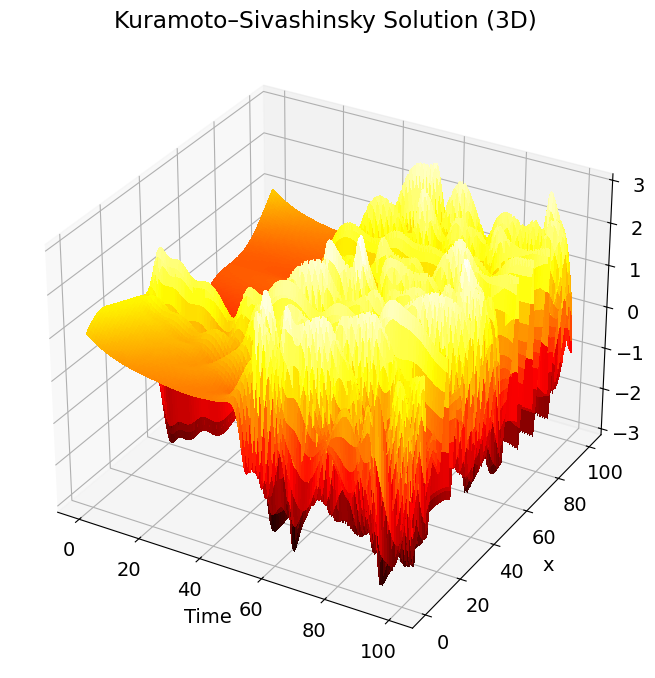

In [3]:
## (a) Simulate the Kuramoto-Sivashinsky equation (ETDRK4 scheme)

def simulate_ks(u0, N, h, tmax, nplt_div=250):
    """Solve KS equation using ETDRK4.  Returns (uu, tt)."""
    v = np.fft.fft(u0)
    k = np.concatenate([np.arange(0, N//2), [0], np.arange(-N//2+1, 0)]) / 16
    L = k**2 - k**4
    E  = np.exp(h * L);  E2 = np.exp(h * L / 2)
    M  = 16
    r  = np.exp(1j * np.pi * (np.arange(1, M+1) - 0.5) / M)
    LR = h * L[:, None] + r[None, :]
    Q  = h * np.real(np.mean((np.exp(LR/2) - 1) / LR, axis=1))
    f1 = h * np.real(np.mean((-4 - LR + np.exp(LR)*(4 - 3*LR + LR**2)) / LR**3, axis=1))
    f2 = h * np.real(np.mean((2 + LR + np.exp(LR)*(-2 + LR)) / LR**3, axis=1))
    f3 = h * np.real(np.mean((-4 - 3*LR - LR**2 + np.exp(LR)*(4 - LR)) / LR**3, axis=1))
    g  = -0.5j * k

    nmax = round(tmax / h)
    nplt = max(1, int(np.floor((tmax / nplt_div) / h)))

    uu = [u0.copy()];  tt = [0.0]
    for n in range(1, nmax + 1):
        Nv = g * np.fft.fft(np.real(np.fft.ifft(v))**2)
        a  = E2 * v + Q * Nv
        Na = g * np.fft.fft(np.real(np.fft.ifft(a))**2)
        b  = E2 * v + Q * Na
        Nb = g * np.fft.fft(np.real(np.fft.ifft(b))**2)
        c  = E2 * a + Q * (2*Nb - Nv)
        Nc = g * np.fft.fft(np.real(np.fft.ifft(c))**2)
        v  = E * v + Nv*f1 + 2*(Na + Nb)*f2 + Nc*f3
        if n % nplt == 0:
            uu.append(np.real(np.fft.ifft(v)))
            tt.append(n * h)
    return np.array(uu).T, np.array(tt)       # uu: (N, n_snapshots)


# --- Generate KS data ---
N_ks = 1024
x_ks = 32 * np.pi * np.arange(1, N_ks+1) / N_ks
h_ks = 0.025
T_ks = 100

u0_default = np.cos(x_ks / 16) * (1 + np.sin(x_ks / 16))
uu_ks, tt_ks = simulate_ks(u0_default, N_ks, h_ks, T_ks)

print(f"KS data shape: {uu_ks.shape}  ({uu_ks.shape[0]} spatial pts × {uu_ks.shape[1]} snapshots)")
print(f"Time range: [{tt_ks[0]:.2f}, {tt_ks[-1]:.2f}],  Δt between snapshots = {tt_ks[1]-tt_ks[0]:.4f}")

# Visualize in 3D
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(111, projection='3d')
TT, XX = np.meshgrid(tt_ks, x_ks)
ax.plot_surface(TT, XX, uu_ks, cmap='hot', rcount=200, ccount=200, antialiased=False)
ax.set_xlabel('Time');  ax.set_ylabel('x');  ax.set_zlabel('u')
ax.set_title('Kuramoto–Sivashinsky Solution (3D)')
ax.view_init(elev=30, azim=-60)
plt.tight_layout();  plt.show()

(1024,)


In [4]:
## (a) Train NN to advance KS solution from t to t+Δt

# Prepare training pairs: u(t_k) -> u(t_{k+1})
ks_input  = uu_ks[:, :-1].T   # (n_snapshots-1, N_ks)
ks_output = uu_ks[:, 1:].T

# Normalize
ks_in_mean, ks_in_std   = ks_input.mean(axis=0),  ks_input.std(axis=0) + 1e-8
ks_out_mean, ks_out_std = ks_output.mean(axis=0), ks_output.std(axis=0) + 1e-8

ks_in_norm  = (ks_input  - ks_in_mean) / ks_in_std
ks_out_norm = (ks_output - ks_out_mean) / ks_out_std

# Train/test split (80/20 temporal)
n_train = int(0.8 * len(ks_in_norm))
X_train_ks = torch.FloatTensor(ks_in_norm[:n_train])
y_train_ks = torch.FloatTensor(ks_out_norm[:n_train])
X_test_ks  = torch.FloatTensor(ks_in_norm[n_train:])
y_test_ks  = torch.FloatTensor(ks_out_norm[n_train:])

train_loader_ks = DataLoader(TensorDataset(X_train_ks, y_train_ks),
                             batch_size=64, shuffle=True)

# Define NN
class KS_Net(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, 256), nn.ReLU(),
            nn.Linear(256, 256), nn.ReLU(),
            nn.Linear(256, 256), nn.ReLU(),
            nn.Linear(256, dim),
        )
    def forward(self, x):
        return self.net(x)

ks_model = KS_Net(N_ks).to(device)
criterion = nn.MSELoss()
optimizer_ks = optim.Adam(ks_model.parameters(), lr=1e-3)
scheduler_ks = optim.lr_scheduler.CosineAnnealingLR(optimizer_ks, T_max=50)

num_epochs_ks = 50
for epoch in tqdm(range(num_epochs_ks), desc="Training KS-NN"):
    ks_model.train()
    epoch_loss = 0.0
    for xb, yb in train_loader_ks:
        xb, yb = xb.to(device), yb.to(device)
        optimizer_ks.zero_grad()
        loss = criterion(ks_model(xb), yb)
        loss.backward();  optimizer_ks.step()
        epoch_loss += loss.item() * xb.size(0)
    scheduler_ks.step()

# Test loss
ks_model.eval()
with torch.no_grad():
    test_pred = ks_model(X_test_ks.to(device)).cpu()
    test_loss = criterion(test_pred, y_test_ks).item()
print(f"Final test MSE (normalized): {test_loss:.6f}")

Training KS-NN: 100%|██████████| 50/50 [00:00<00:00, 62.38it/s]

Final test MSE (normalized): 1.141282


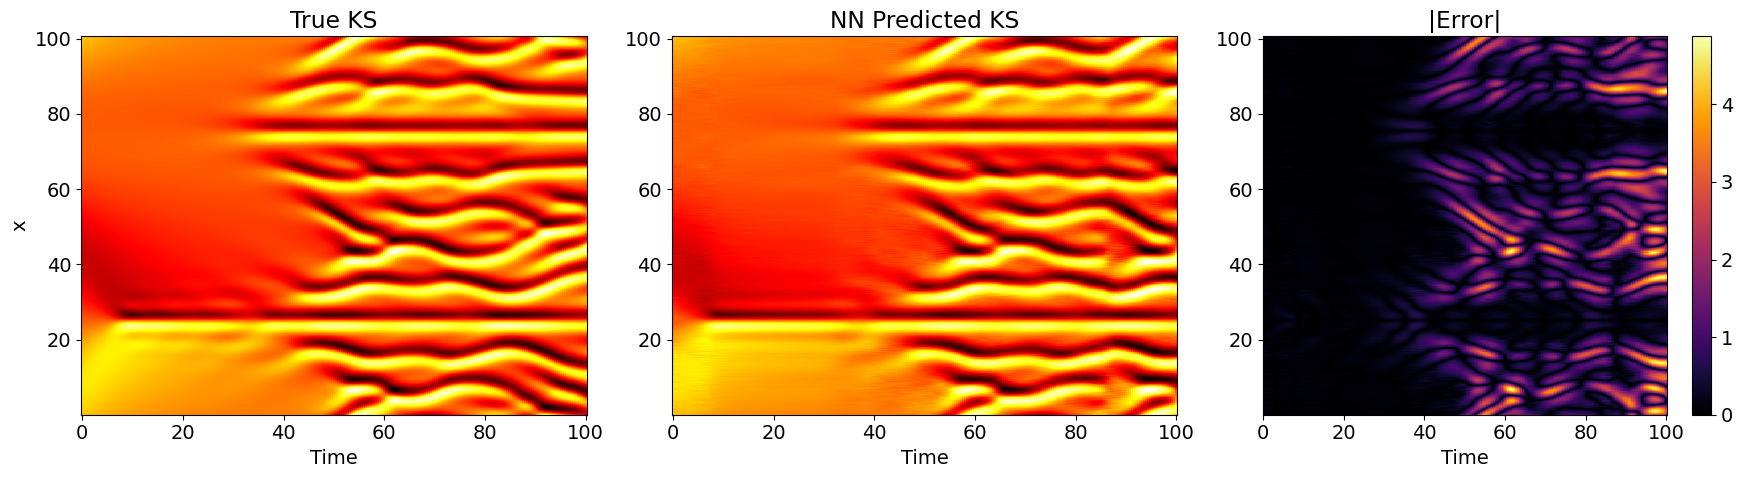

In [5]:
## (b) Autoregressive KS prediction vs true PDE — default initial condition

ks_model.eval()
n_steps_pred = uu_ks.shape[1]  # predict full trajectory

# Roll forward from the first snapshot
u_pred_ks = np.zeros_like(uu_ks)
u_pred_ks[:, 0] = uu_ks[:, 0]

with torch.no_grad():
    for j in range(n_steps_pred - 1):
        inp = (u_pred_ks[:, j] - ks_in_mean) / ks_in_std
        inp_t = torch.FloatTensor(inp).unsqueeze(0).to(device)
        out_t = ks_model(inp_t).cpu().numpy().flatten()
        u_pred_ks[:, j+1] = out_t * ks_out_std + ks_out_mean

# Plot side by side
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
vmin, vmax = uu_ks.min(), uu_ks.max()

axes[0].pcolormesh(tt_ks, x_ks, uu_ks, shading='auto', cmap='hot', vmin=vmin, vmax=vmax)
axes[0].set_title('True KS');  axes[0].set_xlabel('Time');  axes[0].set_ylabel('x')

axes[1].pcolormesh(tt_ks, x_ks, u_pred_ks, shading='auto', cmap='hot', vmin=vmin, vmax=vmax)
axes[1].set_title('NN Predicted KS');  axes[1].set_xlabel('Time')

err = np.abs(uu_ks - u_pred_ks)
im = axes[2].pcolormesh(tt_ks, x_ks, err, shading='auto', cmap='inferno')
axes[2].set_title('|Error|');  axes[2].set_xlabel('Time')
plt.colorbar(im, ax=axes[2])

plt.tight_layout();  plt.show()

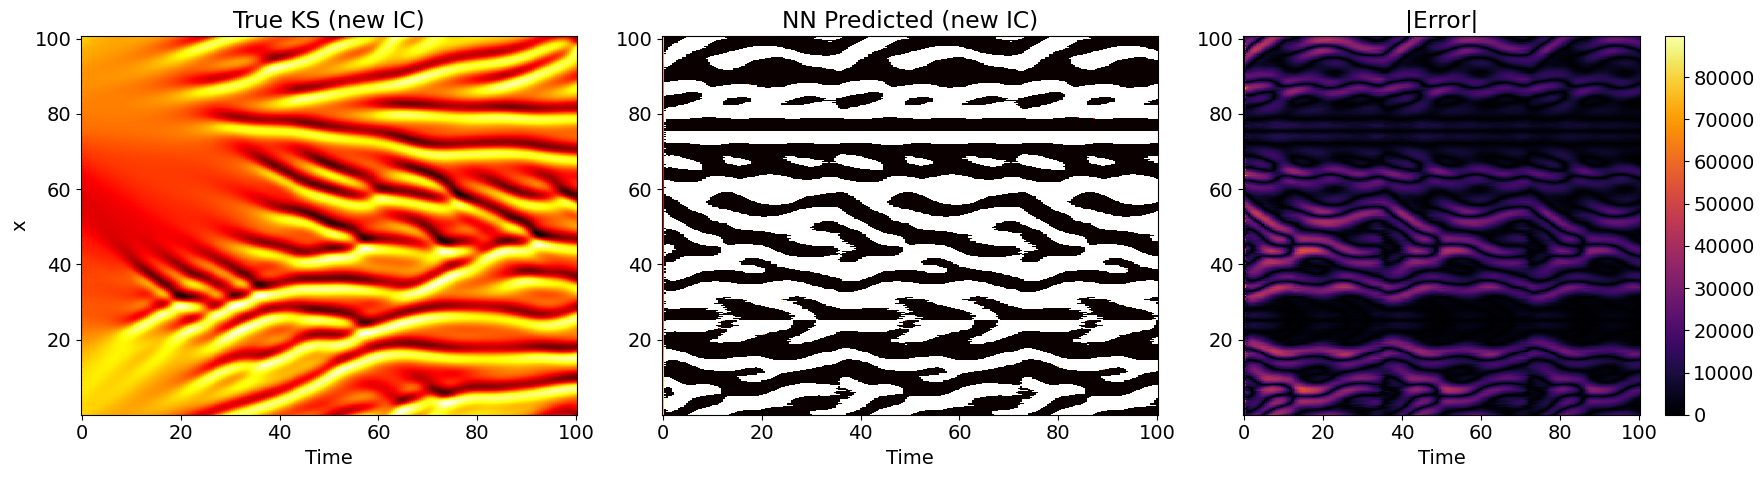

Mean absolute error (new IC): 10152.0071


In [6]:
## (b) Compare with a DIFFERENT initial condition

np.random.seed(42)
u0_new = np.cos(x_ks / 16) * (1 + 0.5*np.sin(x_ks / 8)) + 0.1*np.random.randn(N_ks)
uu_ks2, tt_ks2 = simulate_ks(u0_new, N_ks, h_ks, T_ks)

# NN autoregressive prediction for new IC
u_pred_ks2 = np.zeros_like(uu_ks2)
u_pred_ks2[:, 0] = uu_ks2[:, 0]

with torch.no_grad():
    for j in range(uu_ks2.shape[1] - 1):
        inp = (u_pred_ks2[:, j] - ks_in_mean) / ks_in_std
        inp_t = torch.FloatTensor(inp).unsqueeze(0).to(device)
        out_t = ks_model(inp_t).cpu().numpy().flatten()
        u_pred_ks2[:, j+1] = out_t * ks_out_std + ks_out_mean

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
vmin2, vmax2 = uu_ks2.min(), uu_ks2.max()

axes[0].pcolormesh(tt_ks2, x_ks, uu_ks2, shading='auto', cmap='hot', vmin=vmin2, vmax=vmax2)
axes[0].set_title('True KS (new IC)');  axes[0].set_xlabel('Time');  axes[0].set_ylabel('x')

axes[1].pcolormesh(tt_ks2, x_ks, u_pred_ks2, shading='auto', cmap='hot', vmin=vmin2, vmax=vmax2)
axes[1].set_title('NN Predicted (new IC)');  axes[1].set_xlabel('Time')

err2 = np.abs(uu_ks2 - u_pred_ks2)
im2 = axes[2].pcolormesh(tt_ks2, x_ks, err2, shading='auto', cmap='inferno')
axes[2].set_title('|Error|');  axes[2].set_xlabel('Time')
plt.colorbar(im2, ax=axes[2])

plt.tight_layout();  plt.show()
print(f"Mean absolute error (new IC): {err2.mean():.4f}")

### Part (b′) — Multi-IC Training for KS Generalization

The single-IC model above fails catastrophically on unseen initial conditions. Here we generate **20 random initial conditions** by superposing low-wavenumber Fourier modes with random amplitudes and phases, train on **15 ICs** (pooling all consecutive-snapshot pairs), and test autoregressive rollout on the remaining **5 held-out ICs**.

Generating KS trajectories: 100%|██████████| 200/200 [01:22<00:00,  2.41it/s]



Total training pairs : 48750  (from 195 ICs × 250 steps)
Held-out test ICs    : 5


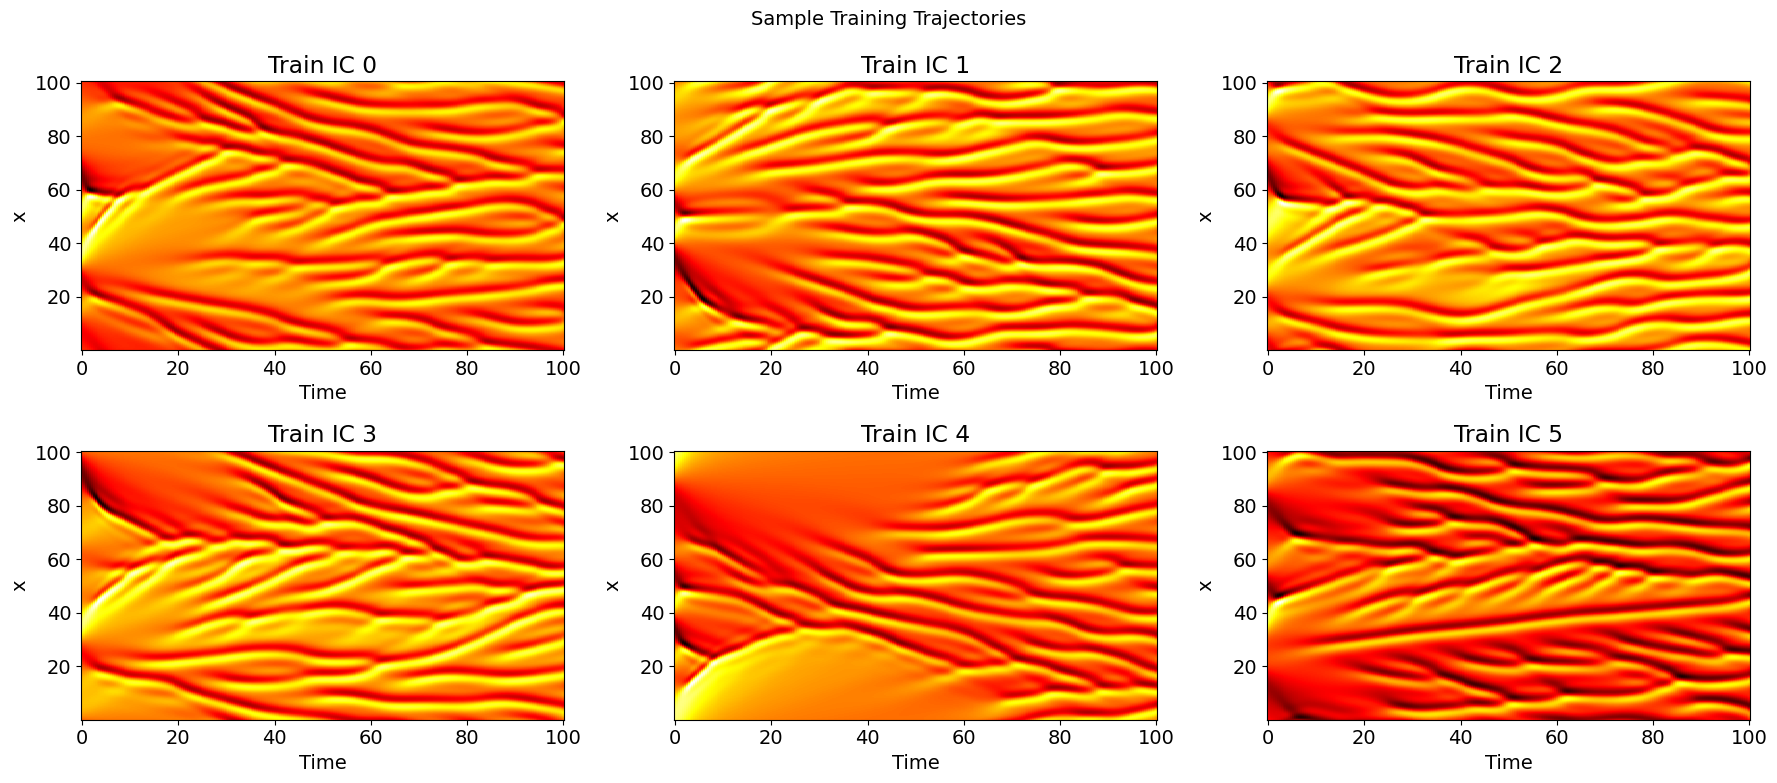

In [30]:
## (b′) Generate many random ICs for the KS equation

def random_ks_ic(x, n_modes=6, amp_range=(0.3, 1.5), seed=None):
    """Random smooth periodic IC as a superposition of low-wavenumber modes."""
    rng = np.random.RandomState(seed)
    u0 = np.zeros_like(x)
    for m in range(1, n_modes + 1):
        a = rng.uniform(*amp_range) * rng.choice([-1, 1])
        phi = rng.uniform(0, 2 * np.pi)
        u0 += a * np.sin(m * x / 16 + phi)
    return u0

# ── Generate 20 trajectories ─────────────────────────────────────────
n_ic_total = 200
n_ic_train = 195
n_ic_test  = n_ic_total - n_ic_train

all_uu, all_tt = [], []
for i in tqdm(range(n_ic_total), desc="Generating KS trajectories"):
    u0_i = random_ks_ic(x_ks, n_modes=6, seed=i)
    uu_i, tt_i = simulate_ks(u0_i, N_ks, h_ks, T_ks)
    all_uu.append(uu_i)
    all_tt.append(tt_i)
    # print(f"  IC {i:2d}  shape {uu_i.shape}  ‖u0‖∞ = {np.abs(u0_i).max():.2f}", end='\r')

# ── Pool consecutive-snapshot pairs from training ICs ─────────────────
train_inputs, train_outputs = [], []
for i in range(n_ic_train):
    uu_i = all_uu[i]
    train_inputs.append(uu_i[:, :-1].T)    # (250, 1024)
    train_outputs.append(uu_i[:, 1:].T)

train_inputs  = np.concatenate(train_inputs,  axis=0)   # (15 × 250, 1024)
train_outputs = np.concatenate(train_outputs, axis=0)

# Global normalization across all training pairs
ks_multi_in_mean  = train_inputs.mean(axis=0)
ks_multi_in_std   = train_inputs.std(axis=0) + 1e-8
ks_multi_out_mean = train_outputs.mean(axis=0)
ks_multi_out_std  = train_outputs.std(axis=0) + 1e-8

train_in_n  = (train_inputs  - ks_multi_in_mean)  / ks_multi_in_std
train_out_n = (train_outputs - ks_multi_out_mean) / ks_multi_out_std

print(f"\nTotal training pairs : {train_in_n.shape[0]}  "
      f"(from {n_ic_train} ICs × {all_uu[0].shape[1]-1} steps)")
print(f"Held-out test ICs    : {n_ic_test}")

# ── Show a few training ICs ──────────────────────────────────────────
fig, axes = plt.subplots(2, 3, figsize=(18, 8))
for idx, ax in enumerate(axes.flat):
    if idx < n_ic_train:
        ax.pcolormesh(all_tt[idx], x_ks, all_uu[idx],
                      shading='auto', cmap='hot')
        ax.set_title(f'Train IC {idx}')
        ax.set_xlabel('Time'); ax.set_ylabel('x')
fig.suptitle('Sample Training Trajectories', fontsize=14)
plt.tight_layout(); plt.show()

In [31]:
## (b′) Train multi-IC KS model

X_train_multi = torch.FloatTensor(train_in_n)
y_train_multi = torch.FloatTensor(train_out_n)
train_loader_multi = DataLoader(
    TensorDataset(X_train_multi, y_train_multi),
    batch_size=128, shuffle=True)

ks_model_multi = KS_Net(N_ks).to(device)
opt_multi   = optim.Adam(ks_model_multi.parameters(), lr=1e-3)
sched_multi = optim.lr_scheduler.CosineAnnealingLR(opt_multi, T_max=80)
crit = nn.MSELoss()

num_epochs_multi = 80
for epoch in tqdm(range(num_epochs_multi), desc="Training multi-IC KS-NN"):
    ks_model_multi.train()
    for xb, yb in train_loader_multi:
        xb, yb = xb.to(device), yb.to(device)
        opt_multi.zero_grad()
        loss = crit(ks_model_multi(xb), yb)
        loss.backward(); opt_multi.step()
    sched_multi.step()

# ── One-step test loss on held-out ICs ────────────────────────────────
ks_model_multi.eval()
test_inputs, test_outputs = [], []
for i in range(n_ic_train, n_ic_total):
    uu_i = all_uu[i]
    test_inputs.append(uu_i[:, :-1].T)
    test_outputs.append(uu_i[:, 1:].T)
test_inputs  = np.concatenate(test_inputs,  axis=0)
test_outputs = np.concatenate(test_outputs, axis=0)

test_in_n  = (test_inputs  - ks_multi_in_mean)  / ks_multi_in_std
test_out_n = (test_outputs - ks_multi_out_mean) / ks_multi_out_std

with torch.no_grad():
    pred_test = ks_model_multi(
        torch.FloatTensor(test_in_n).to(device)).cpu().numpy()
    mse_test = np.mean((pred_test - test_out_n)**2)
print(f"Multi-IC model — one-step test MSE (normalised, {n_ic_test} held-out ICs): "
      f"{mse_test:.6f}")

Training multi-IC KS-NN: 100%|██████████| 80/80 [01:55<00:00,  1.44s/it]

Multi-IC model — one-step test MSE (normalised, 5 held-out ICs): 0.003792


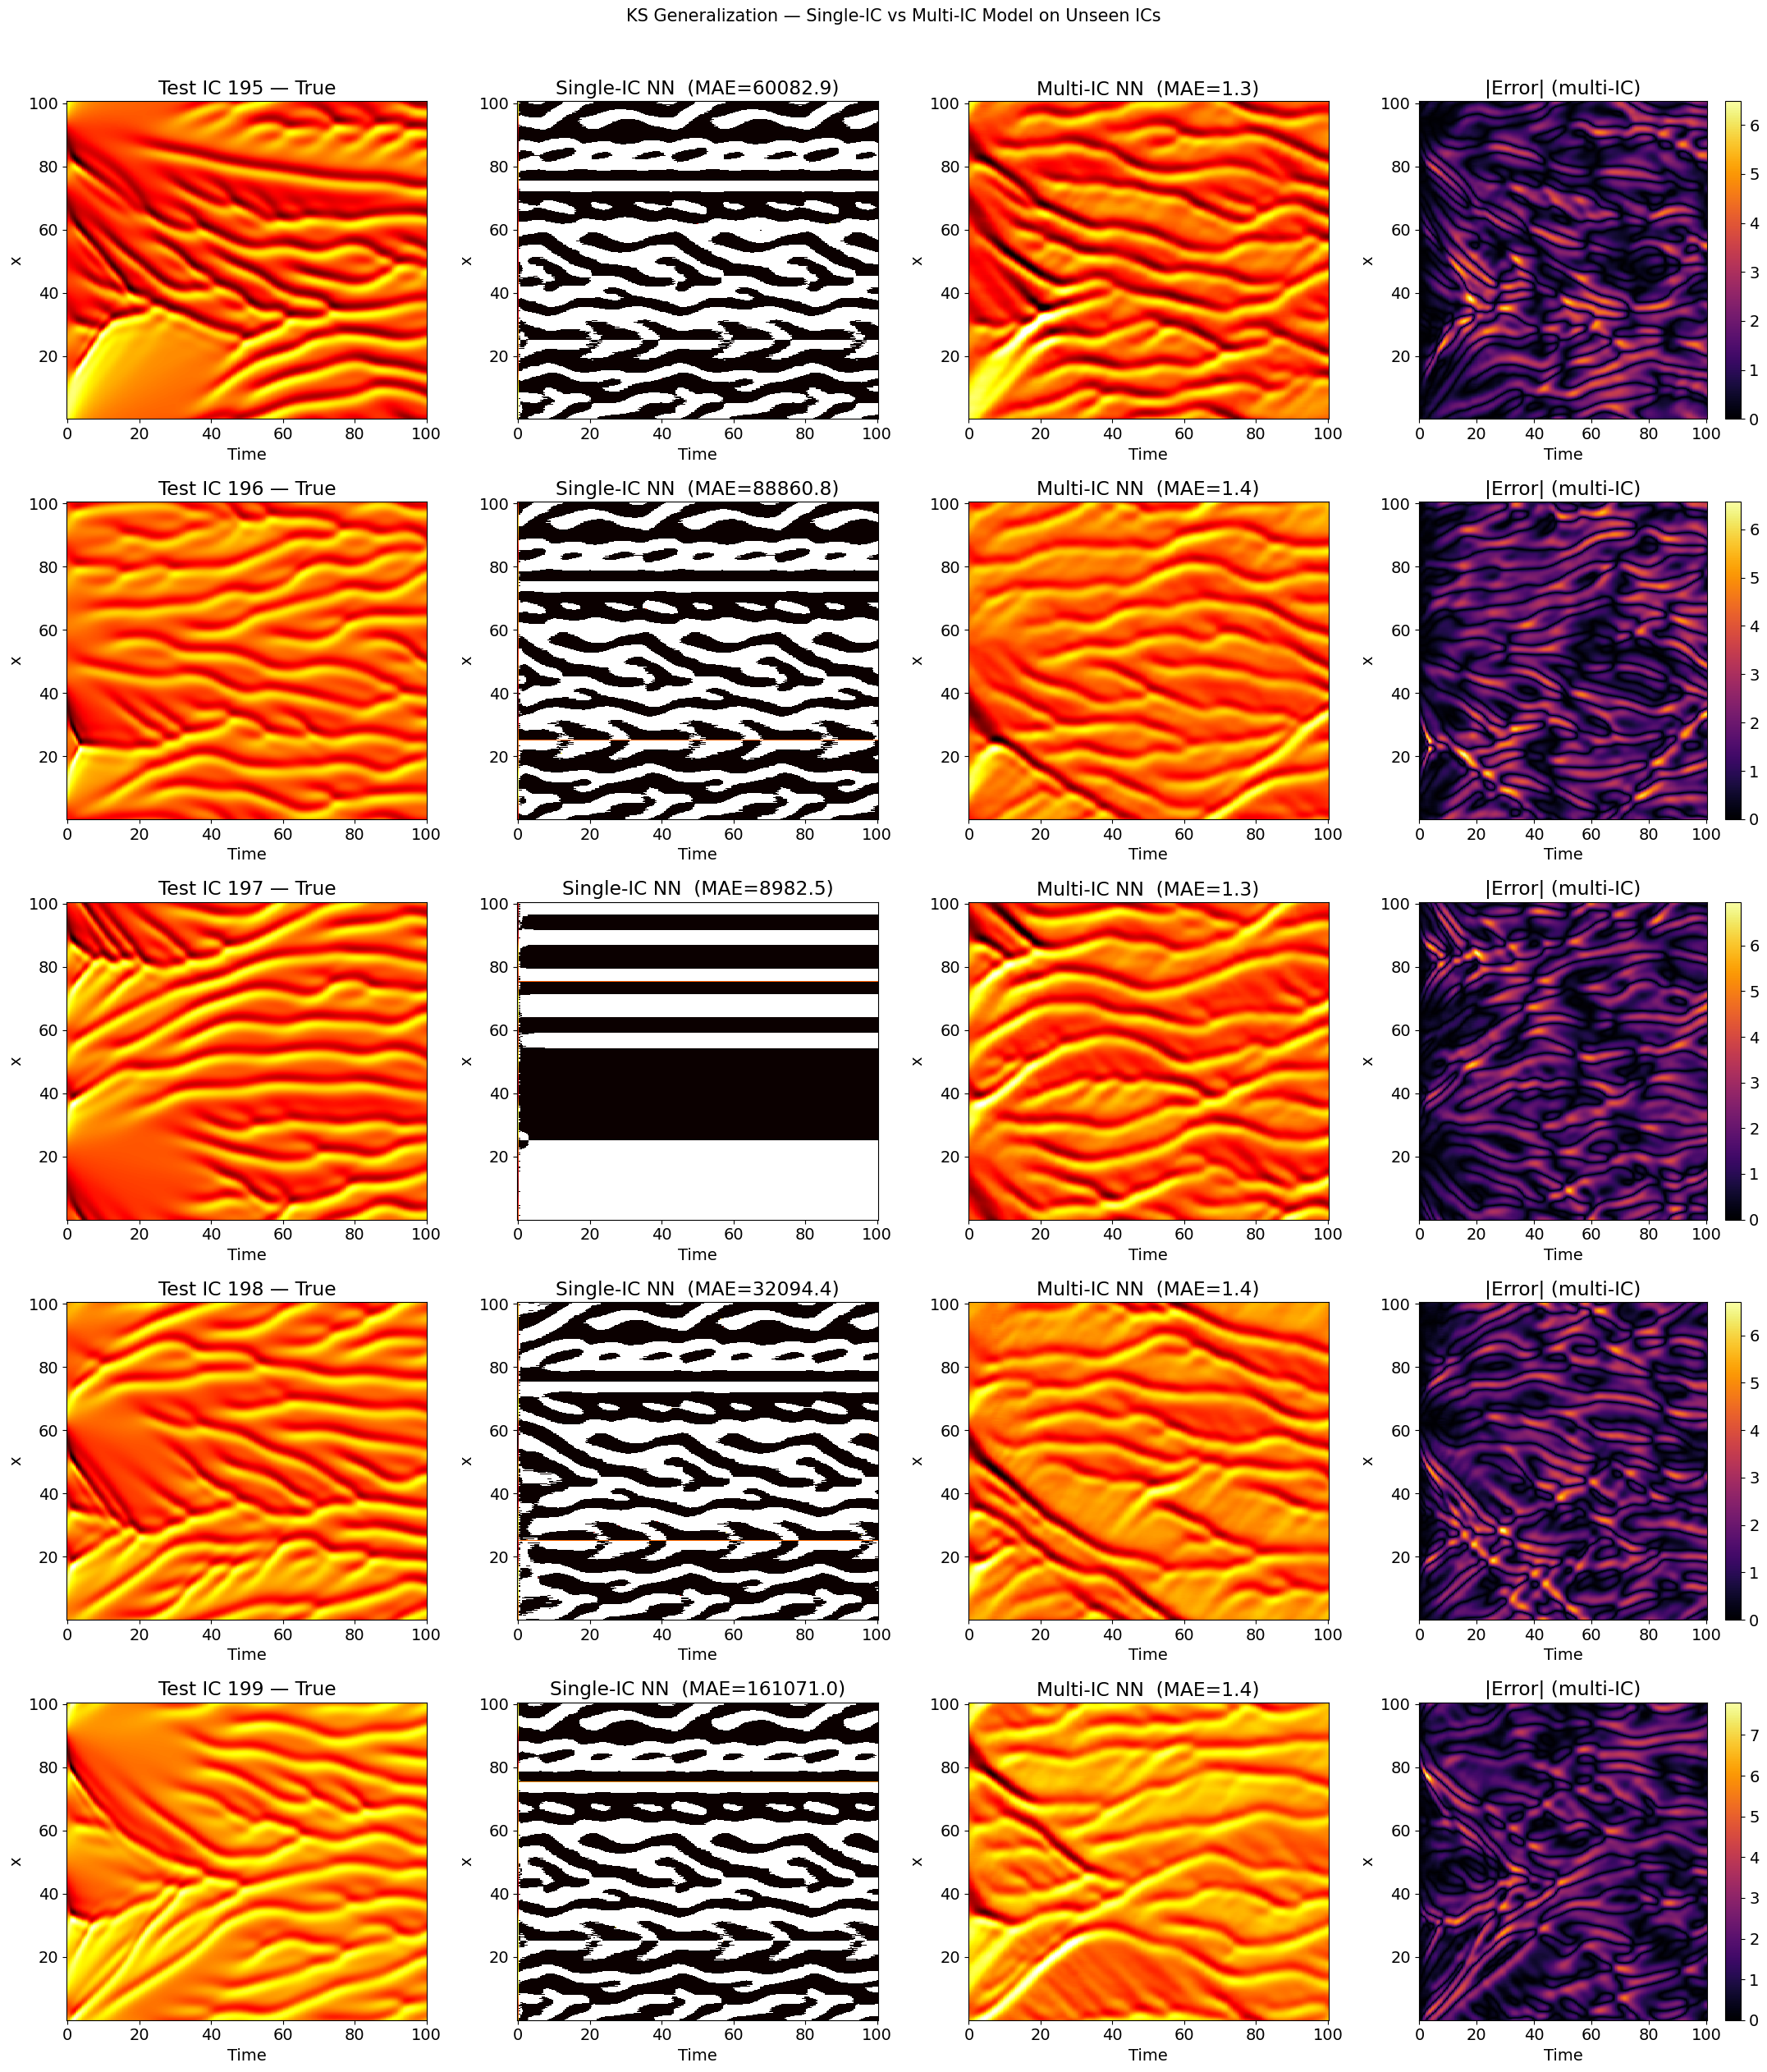


Test IC     Single-IC MAE   Multi-IC MAE  Improvement
────────────────────────────────────────────────────
IC 195          60082.89         1.2623       100.0 %
IC 196          88860.77         1.4015       100.0 %
IC 197           8982.47         1.3470       100.0 %
IC 198          32094.45         1.3582       100.0 %
IC 199         161070.95         1.3912       100.0 %
Average          70218.31         1.3520       100.0 %


In [32]:
## (b′) Autoregressive rollout on held-out ICs — multi-IC vs single-IC model

def rollout_ks(model, u0, n_steps, in_mean, in_std, out_mean, out_std):
    """Autoregressive rollout of a KS model."""
    pred = np.zeros((len(u0), n_steps))
    pred[:, 0] = u0
    model.eval()
    with torch.no_grad():
        for j in range(n_steps - 1):
            inp = (pred[:, j] - in_mean) / in_std
            inp_t = torch.FloatTensor(inp).unsqueeze(0).to(device)
            out_t = model(inp_t).cpu().numpy().flatten()
            pred[:, j+1] = out_t * out_std + out_mean
    return pred

n_show = min(n_ic_test, 5)
fig, axes = plt.subplots(n_show, 4, figsize=(22, 5 * n_show))
if n_show == 1:
    axes = axes[None, :]

mae_single, mae_multi = [], []

for row, ic_idx in enumerate(range(n_ic_train, n_ic_train + n_show)):
    uu_true = all_uu[ic_idx]
    tt      = all_tt[ic_idx]
    n_snap  = uu_true.shape[1]

    # Single-IC model rollout
    pred_s = rollout_ks(ks_model, uu_true[:, 0], n_snap,
                        ks_in_mean, ks_in_std, ks_out_mean, ks_out_std)
    # Multi-IC model rollout
    pred_m = rollout_ks(ks_model_multi, uu_true[:, 0], n_snap,
                        ks_multi_in_mean, ks_multi_in_std,
                        ks_multi_out_mean, ks_multi_out_std)

    e_s = np.abs(uu_true - pred_s).mean()
    e_m = np.abs(uu_true - pred_m).mean()
    mae_single.append(e_s);  mae_multi.append(e_m)

    vlo, vhi = uu_true.min(), uu_true.max()

    axes[row, 0].pcolormesh(tt, x_ks, uu_true, shading='auto',
                            cmap='hot', vmin=vlo, vmax=vhi)
    axes[row, 0].set_title(f'Test IC {ic_idx} — True')

    axes[row, 1].pcolormesh(tt, x_ks, pred_s, shading='auto',
                            cmap='hot', vmin=vlo, vmax=vhi)
    axes[row, 1].set_title(f'Single-IC NN  (MAE={e_s:.1f})')

    axes[row, 2].pcolormesh(tt, x_ks, pred_m, shading='auto',
                            cmap='hot', vmin=vlo, vmax=vhi)
    axes[row, 2].set_title(f'Multi-IC NN  (MAE={e_m:.1f})')

    err_map = np.abs(uu_true - pred_m)
    im = axes[row, 3].pcolormesh(tt, x_ks, err_map, shading='auto',
                                  cmap='inferno')
    axes[row, 3].set_title('|Error| (multi-IC)')
    plt.colorbar(im, ax=axes[row, 3])

    for c in range(4):
        axes[row, c].set_xlabel('Time');  axes[row, c].set_ylabel('x')

fig.suptitle('KS Generalization — Single-IC vs Multi-IC Model on Unseen ICs',
             fontsize=15, y=1.01)
plt.tight_layout(); plt.show()

# ── Summary table ─────────────────────────────────────────────────────
print(f"\n{'Test IC':<10s} {'Single-IC MAE':>14s} {'Multi-IC MAE':>14s} {'Improvement':>12s}")
print('─' * 52)
for row, ic_idx in enumerate(range(n_ic_train, n_ic_train + n_show)):
    s, m = mae_single[row], mae_multi[row]
    imp = (s - m) / s * 100 if s > 0 else 0
    print(f"IC {ic_idx:<6d} {s:14.2f} {m:14.4f} {imp:11.1f} %")
print(f"{'Average':<10s} {np.mean(mae_single):14.2f} "
      f"{np.mean(mae_multi):14.4f} "
      f"{(np.mean(mae_single)-np.mean(mae_multi))/np.mean(mae_single)*100:11.1f} %")

---
# Part (c) — Reaction–Diffusion System with SVD Projection

## Problem Statement
Simulate the λ–ω reaction–diffusion system, project snapshots to a low-rank SVD subspace, train a NN on the SVD coefficients, and forecast in the reduced space.

## Approach
We solve the 2D system in Fourier space with `scipy.integrate.odeint`, compute a truncated SVD of the snapshot matrix, then train a feedforward NN mapping $a(t_k) \mapsto a(t_{k+1})$ where $a$ are the SVD coordinates.

Solving reaction-diffusion on 64×64 grid, 201 time steps ...
Done.


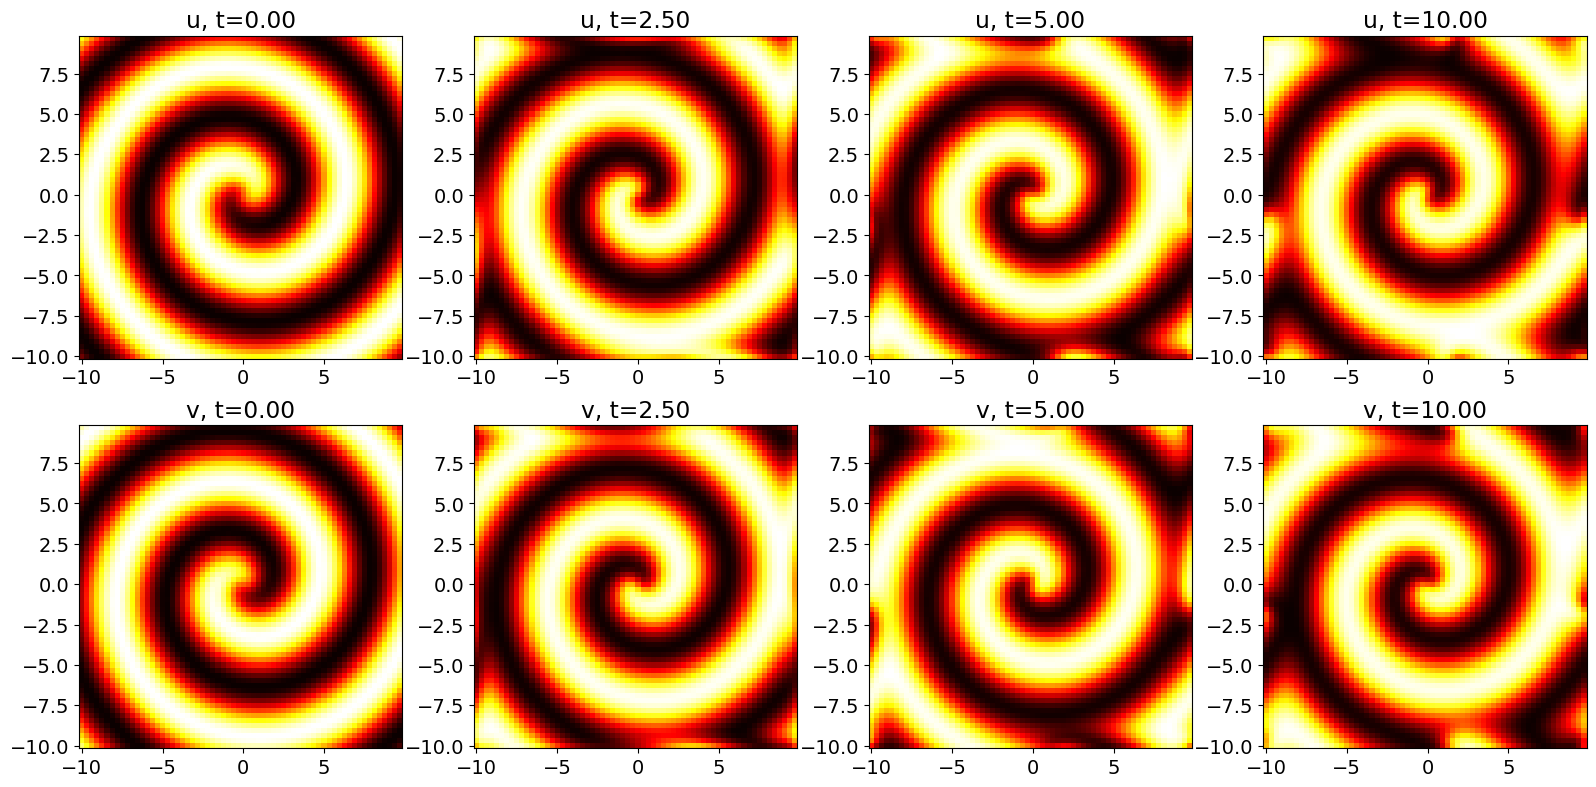

In [8]:
## (c) Simulate the reaction-diffusion system
# Note: odeint requires real arrays, so we split complex Fourier coefficients
# into real and imaginary parts: state = [Re(u_hat), Im(u_hat), Re(v_hat), Im(v_hat)]

def reaction_diffusion_rhs(state, t_val, K22, d1, d2, beta, n, N_rd):
    """RHS in Fourier space for the λ–ω reaction-diffusion system.
    State is real-valued: [Re(uhat), Im(uhat), Re(vhat), Im(vhat)]."""
    # Reconstruct complex Fourier coefficients
    u_hat = (state[:N_rd] + 1j * state[N_rd:2*N_rd]).reshape(n, n)
    v_hat = (state[2*N_rd:3*N_rd] + 1j * state[3*N_rd:]).reshape(n, n)
    u = np.real(np.fft.ifft2(u_hat))
    v = np.real(np.fft.ifft2(v_hat))
    # Reaction terms
    u3  = u**3;  v3  = v**3
    u2v = u**2 * v;  uv2 = u * v**2
    utrhs = np.fft.fft2(u - u3 - uv2 + beta*u2v + beta*v3).reshape(N_rd)
    vtrhs = np.fft.fft2(v - u2v - v3 - beta*u3 - beta*uv2).reshape(N_rd)
    # Diffusion + reaction
    du_hat = -d1 * K22 * (state[:N_rd] + 1j * state[N_rd:2*N_rd]) + utrhs
    dv_hat = -d2 * K22 * (state[2*N_rd:3*N_rd] + 1j * state[3*N_rd:]) + vtrhs
    # Return as real: [Re(du), Im(du), Re(dv), Im(dv)]
    return np.concatenate([du_hat.real, du_hat.imag, dv_hat.real, dv_hat.imag])

# Parameters (use smaller grid for tractability: n=64 instead of 512)
n_rd = 64;  N_rd = n_rd**2
L_rd = 20;  d1 = 0.1;  d2 = 0.1;  beta_rd = 1.0
t_rd = np.arange(0, 10.05, 0.05)

x_rd = np.linspace(-L_rd/2, L_rd/2, n_rd, endpoint=False)
kx_rd = (2*np.pi / L_rd) * np.concatenate([np.arange(0, n_rd//2), np.arange(-n_rd//2, 0)])
KX, KY = np.meshgrid(kx_rd, kx_rd)
K22_rd = (KX**2 + KY**2).reshape(N_rd)

X_rd, Y_rd = np.meshgrid(x_rd, x_rd)
m_spiral = 1
u0_rd = np.tanh(np.sqrt(X_rd**2 + Y_rd**2)) * np.cos(m_spiral*np.angle(X_rd + 1j*Y_rd) - np.sqrt(X_rd**2 + Y_rd**2))
v0_rd = np.tanh(np.sqrt(X_rd**2 + Y_rd**2)) * np.sin(m_spiral*np.angle(X_rd + 1j*Y_rd) - np.sqrt(X_rd**2 + Y_rd**2))

# Pack initial condition as real: [Re(u_hat), Im(u_hat), Re(v_hat), Im(v_hat)]
u0_hat = np.fft.fft2(u0_rd).reshape(N_rd)
v0_hat = np.fft.fft2(v0_rd).reshape(N_rd)
state0 = np.concatenate([u0_hat.real, u0_hat.imag, v0_hat.real, v0_hat.imag])

print(f"Solving reaction-diffusion on {n_rd}×{n_rd} grid, {len(t_rd)} time steps ...")
sol = odeint(reaction_diffusion_rhs, state0, t_rd,
             args=(K22_rd, d1, d2, beta_rd, n_rd, N_rd), rtol=1e-6, atol=1e-8)
print("Done.")

# Extract u and v fields
u_rd = np.zeros((n_rd, n_rd, len(t_rd)))
v_rd = np.zeros_like(u_rd)
for j in range(len(t_rd)):
    u_hat_j = (sol[j, :N_rd] + 1j * sol[j, N_rd:2*N_rd]).reshape(n_rd, n_rd)
    v_hat_j = (sol[j, 2*N_rd:3*N_rd] + 1j * sol[j, 3*N_rd:]).reshape(n_rd, n_rd)
    u_rd[:,:,j] = np.real(np.fft.ifft2(u_hat_j))
    v_rd[:,:,j] = np.real(np.fft.ifft2(v_hat_j))

# Visualize a few snapshots
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
snap_idxs = [0, len(t_rd)//4, len(t_rd)//2, -1]
for col, si in enumerate(snap_idxs):
    axes[0, col].pcolormesh(x_rd, x_rd, u_rd[:,:,si], shading='auto', cmap='hot')
    axes[0, col].set_title(f'u, t={t_rd[si]:.2f}');  axes[0, col].set_aspect('equal')
    axes[1, col].pcolormesh(x_rd, x_rd, v_rd[:,:,si], shading='auto', cmap='hot')
    axes[1, col].set_title(f'v, t={t_rd[si]:.2f}');  axes[1, col].set_aspect('equal')
plt.tight_layout();  plt.show()

Rank for 99% energy: r = 3


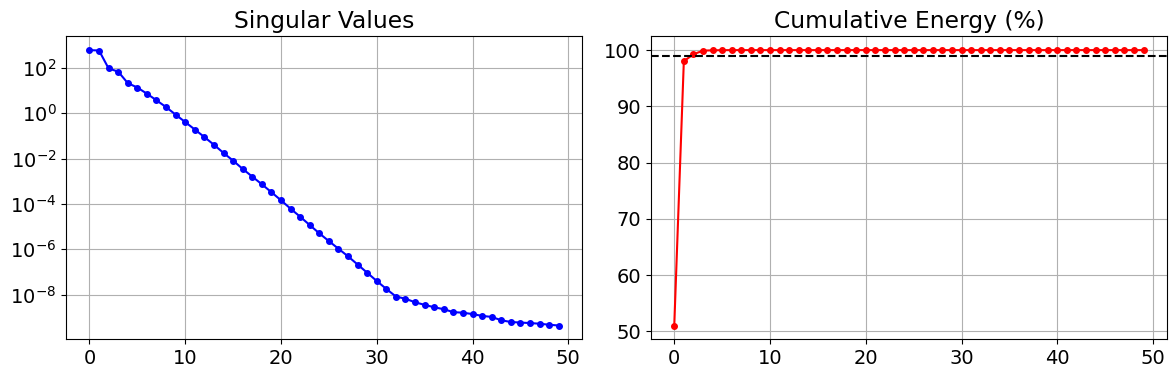

Training SVD-NN: 100%|██████████| 80/80 [00:00<00:00, 231.58it/s]

SVD-NN training complete.


In [9]:
## (c) SVD projection and NN forecasting in low-rank space

# Build snapshot matrix: each column = flattened [u; v] at time t_k
snap_matrix = np.vstack([
    u_rd.reshape(N_rd, len(t_rd)),
    v_rd.reshape(N_rd, len(t_rd))
])  # (2*N_rd, n_time)

# Truncated SVD
U_svd, s_svd, Vt_svd = np.linalg.svd(snap_matrix, full_matrices=False)
cumulative_energy = np.cumsum(s_svd**2) / np.sum(s_svd**2)
r_svd = np.argmax(cumulative_energy >= 0.99) + 1
print(f"Rank for 99% energy: r = {r_svd}")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].semilogy(s_svd[:50], 'bo-', ms=4);  axes[0].set_title('Singular Values');  axes[0].grid(True)
axes[1].plot(cumulative_energy[:50]*100, 'ro-', ms=4);  axes[1].axhline(99, ls='--', color='k')
axes[1].set_title('Cumulative Energy (%)');  axes[1].grid(True)
plt.tight_layout();  plt.show()

# SVD coefficients: a(t_k) = Σ_r V_r^T row k  (or equivalently U_r^T @ snapshot)
U_r = U_svd[:, :r_svd]
a_coeffs = np.diag(s_svd[:r_svd]) @ Vt_svd[:r_svd, :]  # (r_svd, n_time)

# NN: a(t_k) -> a(t_{k+1})
a_in  = a_coeffs[:, :-1].T   # (n_time-1, r_svd)
a_out = a_coeffs[:, 1:].T

a_mean, a_std = a_in.mean(0), a_in.std(0) + 1e-8
a_in_n  = (a_in  - a_mean) / a_std
a_out_n = (a_out - a_mean) / a_std   # same normalization since same space

X_a = torch.FloatTensor(a_in_n)
y_a = torch.FloatTensor(a_out_n)
loader_a = DataLoader(TensorDataset(X_a, y_a), batch_size=32, shuffle=True)

class SVD_Net(nn.Module):
    def __init__(self, r):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(r, 128), nn.ReLU(),
            nn.Linear(128, 128), nn.ReLU(),
            nn.Linear(128, r),
        )
    def forward(self, x):
        return self.net(x)

svd_model = SVD_Net(r_svd).to(device)
opt_svd = optim.Adam(svd_model.parameters(), lr=1e-3)
sched_svd = optim.lr_scheduler.CosineAnnealingLR(opt_svd, T_max=80)

for epoch in tqdm(range(80), desc="Training SVD-NN"):
    svd_model.train()
    for xb, yb in loader_a:
        xb, yb = xb.to(device), yb.to(device)
        opt_svd.zero_grad()
        loss = nn.MSELoss()(svd_model(xb), yb)
        loss.backward();  opt_svd.step()
    sched_svd.step()

print("SVD-NN training complete.")

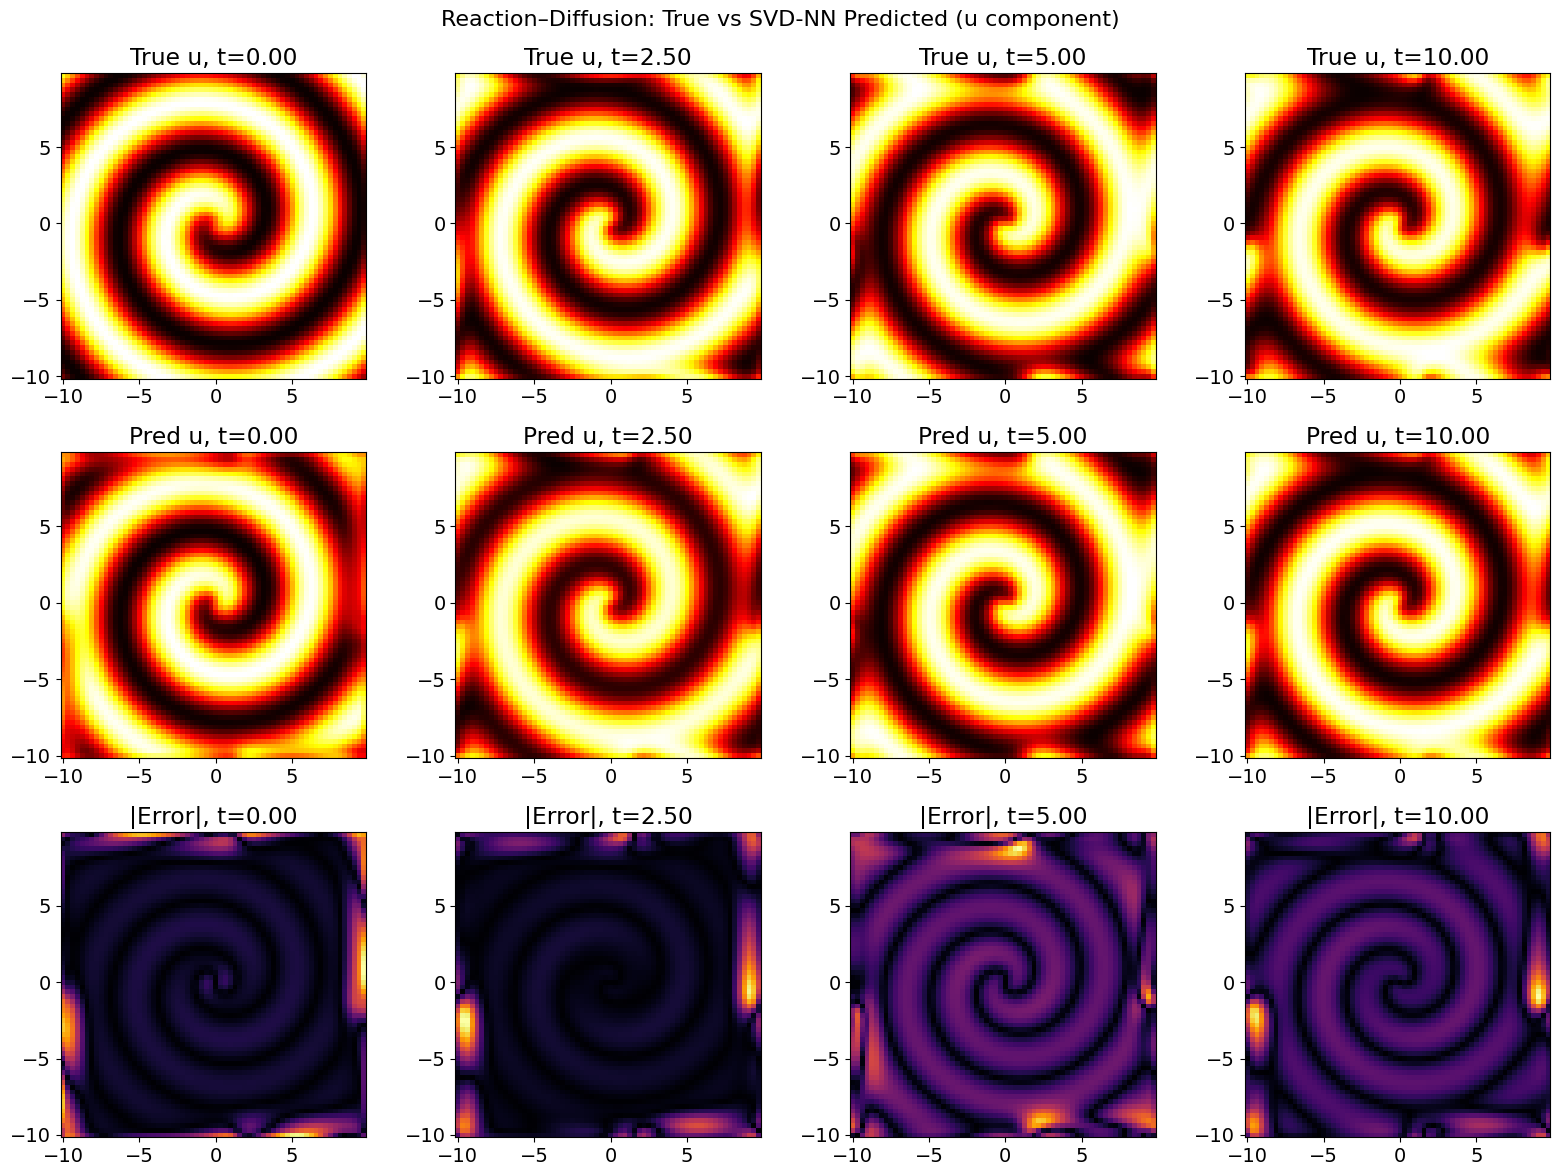

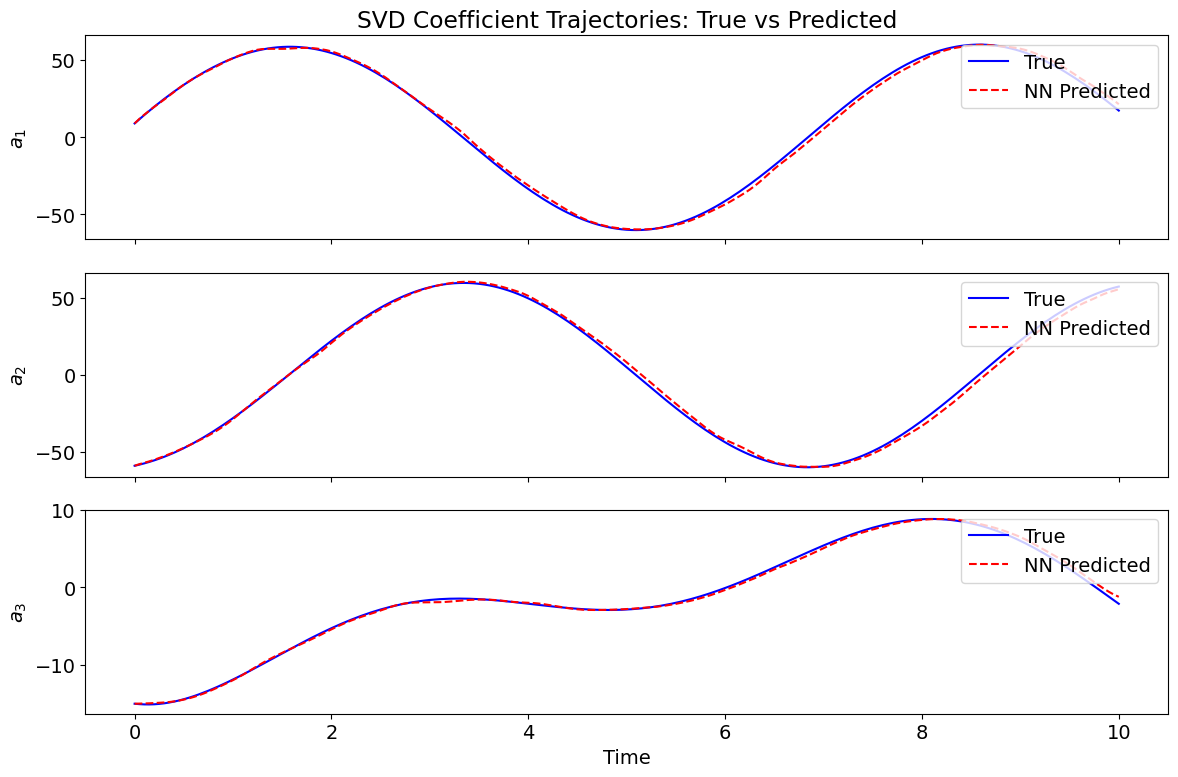

In [10]:
## (c) Autoregressive prediction in SVD space and reconstruction

svd_model.eval()
a_pred = np.zeros_like(a_coeffs)
a_pred[:, 0] = a_coeffs[:, 0]

with torch.no_grad():
    for j in range(a_coeffs.shape[1] - 1):
        inp = (a_pred[:, j] - a_mean) / a_std
        inp_t = torch.FloatTensor(inp).unsqueeze(0).to(device)
        out_t = svd_model(inp_t).cpu().numpy().flatten()
        a_pred[:, j+1] = out_t * a_std + a_mean

# Reconstruct full fields from predicted SVD coefficients
snap_pred = U_r @ a_pred
u_pred_rd = snap_pred[:N_rd, :].reshape(n_rd, n_rd, len(t_rd))
v_pred_rd = snap_pred[N_rd:, :].reshape(n_rd, n_rd, len(t_rd))

# Compare
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
snap_idxs = [0, len(t_rd)//4, len(t_rd)//2, -1]
for col, si in enumerate(snap_idxs):
    axes[0, col].pcolormesh(x_rd, x_rd, u_rd[:,:,si], shading='auto', cmap='hot')
    axes[0, col].set_title(f'True u, t={t_rd[si]:.2f}');  axes[0, col].set_aspect('equal')
    axes[1, col].pcolormesh(x_rd, x_rd, u_pred_rd[:,:,si], shading='auto', cmap='hot')
    axes[1, col].set_title(f'Pred u, t={t_rd[si]:.2f}');  axes[1, col].set_aspect('equal')
    axes[2, col].pcolormesh(x_rd, x_rd, np.abs(u_rd[:,:,si] - u_pred_rd[:,:,si]), shading='auto', cmap='inferno')
    axes[2, col].set_title(f'|Error|, t={t_rd[si]:.2f}');  axes[2, col].set_aspect('equal')
plt.suptitle('Reaction–Diffusion: True vs SVD-NN Predicted (u component)', fontsize=16)
plt.tight_layout();  plt.show()

# Plot SVD coefficient trajectories
fig, axes = plt.subplots(min(r_svd, 4), 1, figsize=(12, 8), sharex=True)
for i in range(min(r_svd, 4)):
    axes[i].plot(t_rd, a_coeffs[i, :], 'b', label='True', lw=1.5)
    axes[i].plot(t_rd, a_pred[i, :], 'r--', label='NN Predicted', lw=1.5)
    axes[i].set_ylabel(f'$a_{{{i+1}}}$');  axes[i].legend(loc='upper right')
axes[-1].set_xlabel('Time')
axes[0].set_title('SVD Coefficient Trajectories: True vs Predicted')
plt.tight_layout();  plt.show()

Solving reaction-diffusion with new IC (m=2 spirals) ...
Done.


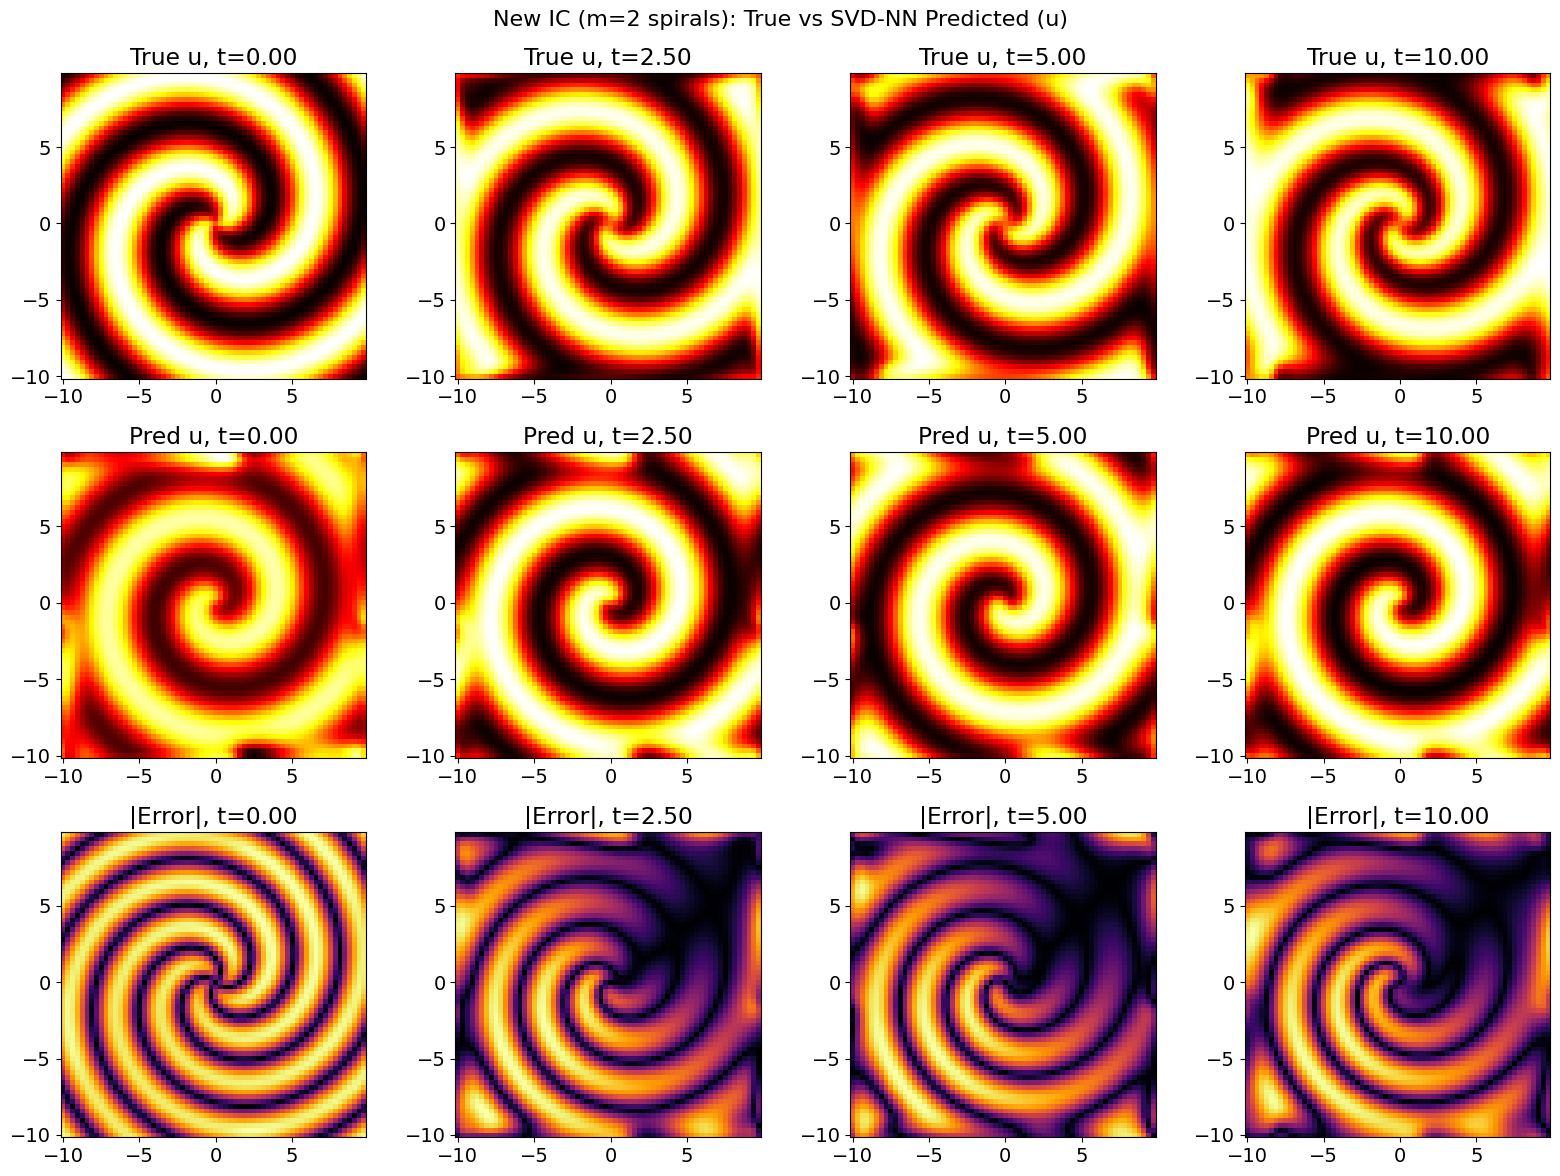

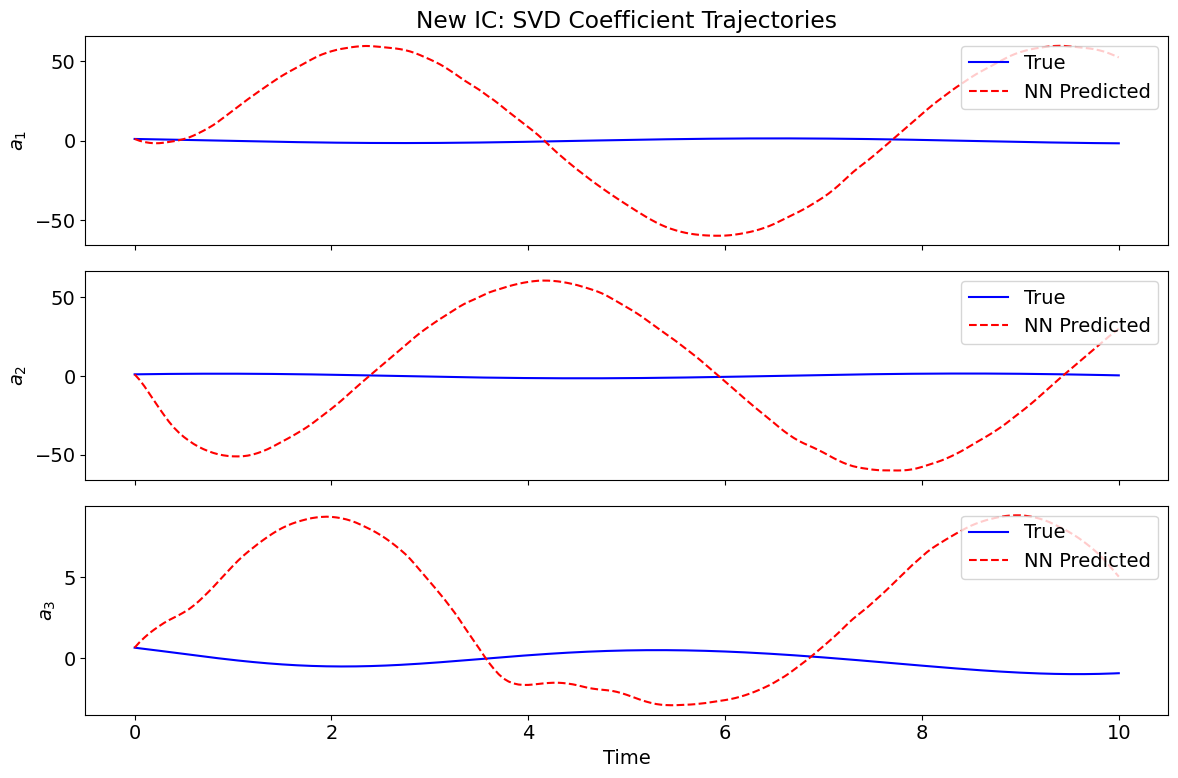

SVD reconstruction error for new IC (r=3): 0.9997 (99.97%)
  → If this is large, the new IC's dynamics live outside the training SVD subspace.


In [11]:
## (c) Test with a DIFFERENT initial condition

# New IC: 2 spirals instead of 1
m_spiral_new = 2
u0_new_rd = np.tanh(np.sqrt(X_rd**2 + Y_rd**2)) * np.cos(m_spiral_new*np.angle(X_rd + 1j*Y_rd) - np.sqrt(X_rd**2 + Y_rd**2))
v0_new_rd = np.tanh(np.sqrt(X_rd**2 + Y_rd**2)) * np.sin(m_spiral_new*np.angle(X_rd + 1j*Y_rd) - np.sqrt(X_rd**2 + Y_rd**2))

u0h_new = np.fft.fft2(u0_new_rd).reshape(N_rd)
v0h_new = np.fft.fft2(v0_new_rd).reshape(N_rd)
state0_new = np.concatenate([u0h_new.real, u0h_new.imag, v0h_new.real, v0h_new.imag])

print("Solving reaction-diffusion with new IC (m=2 spirals) ...")
sol_new = odeint(reaction_diffusion_rhs, state0_new, t_rd,
                 args=(K22_rd, d1, d2, beta_rd, n_rd, N_rd), rtol=1e-6, atol=1e-8)
print("Done.")

# Extract true fields
u_rd_new = np.zeros((n_rd, n_rd, len(t_rd)))
v_rd_new = np.zeros_like(u_rd_new)
for j in range(len(t_rd)):
    uh = (sol_new[j, :N_rd] + 1j * sol_new[j, N_rd:2*N_rd]).reshape(n_rd, n_rd)
    vh = (sol_new[j, 2*N_rd:3*N_rd] + 1j * sol_new[j, 3*N_rd:]).reshape(n_rd, n_rd)
    u_rd_new[:,:,j] = np.real(np.fft.ifft2(uh))
    v_rd_new[:,:,j] = np.real(np.fft.ifft2(vh))

# Project new trajectory into the EXISTING SVD basis (U_r from training)
snap_new = np.vstack([u_rd_new.reshape(N_rd, len(t_rd)),
                      v_rd_new.reshape(N_rd, len(t_rd))])
a_new_true = U_r.T @ snap_new  # (r_svd, n_time) — true SVD coefficients for new IC

# Autoregressive NN prediction in SVD space
svd_model.eval()
a_new_pred = np.zeros_like(a_new_true)
a_new_pred[:, 0] = a_new_true[:, 0]  # seed with true initial SVD coefficients

with torch.no_grad():
    for j in range(a_new_true.shape[1] - 1):
        inp = (a_new_pred[:, j] - a_mean) / a_std
        inp_t = torch.FloatTensor(inp).unsqueeze(0).to(device)
        out_t = svd_model(inp_t).cpu().numpy().flatten()
        a_new_pred[:, j+1] = out_t * a_std + a_mean

# Reconstruct fields
snap_new_pred = U_r @ a_new_pred
u_pred_new = snap_new_pred[:N_rd, :].reshape(n_rd, n_rd, len(t_rd))

# --- Visualize ---
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
for col, si in enumerate(snap_idxs):
    axes[0, col].pcolormesh(x_rd, x_rd, u_rd_new[:,:,si], shading='auto', cmap='hot')
    axes[0, col].set_title(f'True u, t={t_rd[si]:.2f}');  axes[0, col].set_aspect('equal')
    axes[1, col].pcolormesh(x_rd, x_rd, u_pred_new[:,:,si], shading='auto', cmap='hot')
    axes[1, col].set_title(f'Pred u, t={t_rd[si]:.2f}');  axes[1, col].set_aspect('equal')
    axes[2, col].pcolormesh(x_rd, x_rd, np.abs(u_rd_new[:,:,si] - u_pred_new[:,:,si]),
                            shading='auto', cmap='inferno')
    axes[2, col].set_title(f'|Error|, t={t_rd[si]:.2f}');  axes[2, col].set_aspect('equal')
plt.suptitle('New IC (m=2 spirals): True vs SVD-NN Predicted (u)', fontsize=16)
plt.tight_layout();  plt.show()

# SVD coefficient comparison
fig2, axes2 = plt.subplots(min(r_svd, 4), 1, figsize=(12, 8), sharex=True)
for i in range(min(r_svd, 4)):
    axes2[i].plot(t_rd, a_new_true[i, :], 'b', label='True', lw=1.5)
    axes2[i].plot(t_rd, a_new_pred[i, :], 'r--', label='NN Predicted', lw=1.5)
    axes2[i].set_ylabel(f'$a_{{{i+1}}}$');  axes2[i].legend(loc='upper right')
axes2[-1].set_xlabel('Time')
axes2[0].set_title('New IC: SVD Coefficient Trajectories')
plt.tight_layout();  plt.show()

# Reconstruction quality
recon_err = np.linalg.norm(snap_new - U_r @ a_new_true, 'fro') / np.linalg.norm(snap_new, 'fro')
print(f"SVD reconstruction error for new IC (r={r_svd}): {recon_err:.4f} ({recon_err*100:.2f}%)")
print(f"  → If this is large, the new IC's dynamics live outside the training SVD subspace.")

---
# Part (d) — Lorenz: Multi-$\rho$ Training and Generalization

## Problem Statement
Train a NN to advance the Lorenz solution from $t$ to $t+\Delta t$ for $\rho = 10, 28, 40$. Test generalization for $\rho = 17$ and $\rho = 35$.

## Approach
We include $\rho$ as a 4th input feature so the NN learns a $\rho$-parametric map: $(x, y, z, \rho) \mapsto (x', y', z')$. We then evaluate on unseen $\rho$ values.

In [12]:
## (d) Generate Lorenz training data for ρ = 10, 28, 40

dt_lor = 0.01;  T_lor = 8
t_lor = np.arange(0, T_lor + dt_lor, dt_lor)
sigma_lor = 10;  beta_lor = 8/3

def lorenz(xyz, t0, sigma, beta, rho):
    x, y, z = xyz
    return [sigma*(y - x), x*(rho - z) - y, x*y - beta*z]

rho_train = [10, 28, 40]
n_traj = 50  # trajectories per ρ

all_input = [];  all_output = []

np.random.seed(123)
for rho_val in rho_train:
    x0s = -15 + 30 * np.random.random((n_traj, 3))
    x_t_lor = np.array([odeint(lorenz, x0j, t_lor,
                                args=(sigma_lor, beta_lor, rho_val)) for x0j in x0s])
    for j in range(n_traj):
        states = x_t_lor[j]  # (len(t_lor), 3)
        rho_col = np.full((len(t_lor)-1, 1), rho_val)
        all_input.append(np.hstack([states[:-1], rho_col]))    # (x,y,z,ρ)
        all_output.append(states[1:])                           # (x',y',z')

all_input  = np.vstack(all_input)
all_output = np.vstack(all_output)
print(f"Training data: {all_input.shape[0]} samples, input dim = {all_input.shape[1]}")

# Normalize
lor_in_mean, lor_in_std   = all_input.mean(0),  all_input.std(0) + 1e-8
lor_out_mean, lor_out_std = all_output.mean(0), all_output.std(0) + 1e-8
all_in_n  = (all_input  - lor_in_mean) / lor_in_std
all_out_n = (all_output - lor_out_mean) / lor_out_std

X_lor = torch.FloatTensor(all_in_n)
y_lor = torch.FloatTensor(all_out_n)
loader_lor = DataLoader(TensorDataset(X_lor, y_lor), batch_size=512, shuffle=True)

# NN
class LorenzMultiRho(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(4, 128), nn.ReLU(),
            nn.Linear(128, 128), nn.ReLU(),
            nn.Linear(128, 3),
        )
    def forward(self, x):
        return self.net(x)

lor_model = LorenzMultiRho().to(device)
opt_lor = optim.Adam(lor_model.parameters(), lr=1e-3)
sched_lor = optim.lr_scheduler.CosineAnnealingLR(opt_lor, T_max=60)

for epoch in tqdm(range(60), desc="Training Lorenz multi-ρ"):
    lor_model.train()
    for xb, yb in loader_lor:
        xb, yb = xb.to(device), yb.to(device)
        opt_lor.zero_grad()
        loss = nn.MSELoss()(lor_model(xb), yb)
        loss.backward();  opt_lor.step()
    sched_lor.step()

print("Multi-ρ Lorenz NN training complete.")

Training data: 120000 samples, input dim = 4


Training Lorenz multi-ρ: 100%|██████████| 60/60 [00:37<00:00,  1.59it/s]

Multi-ρ Lorenz NN training complete.


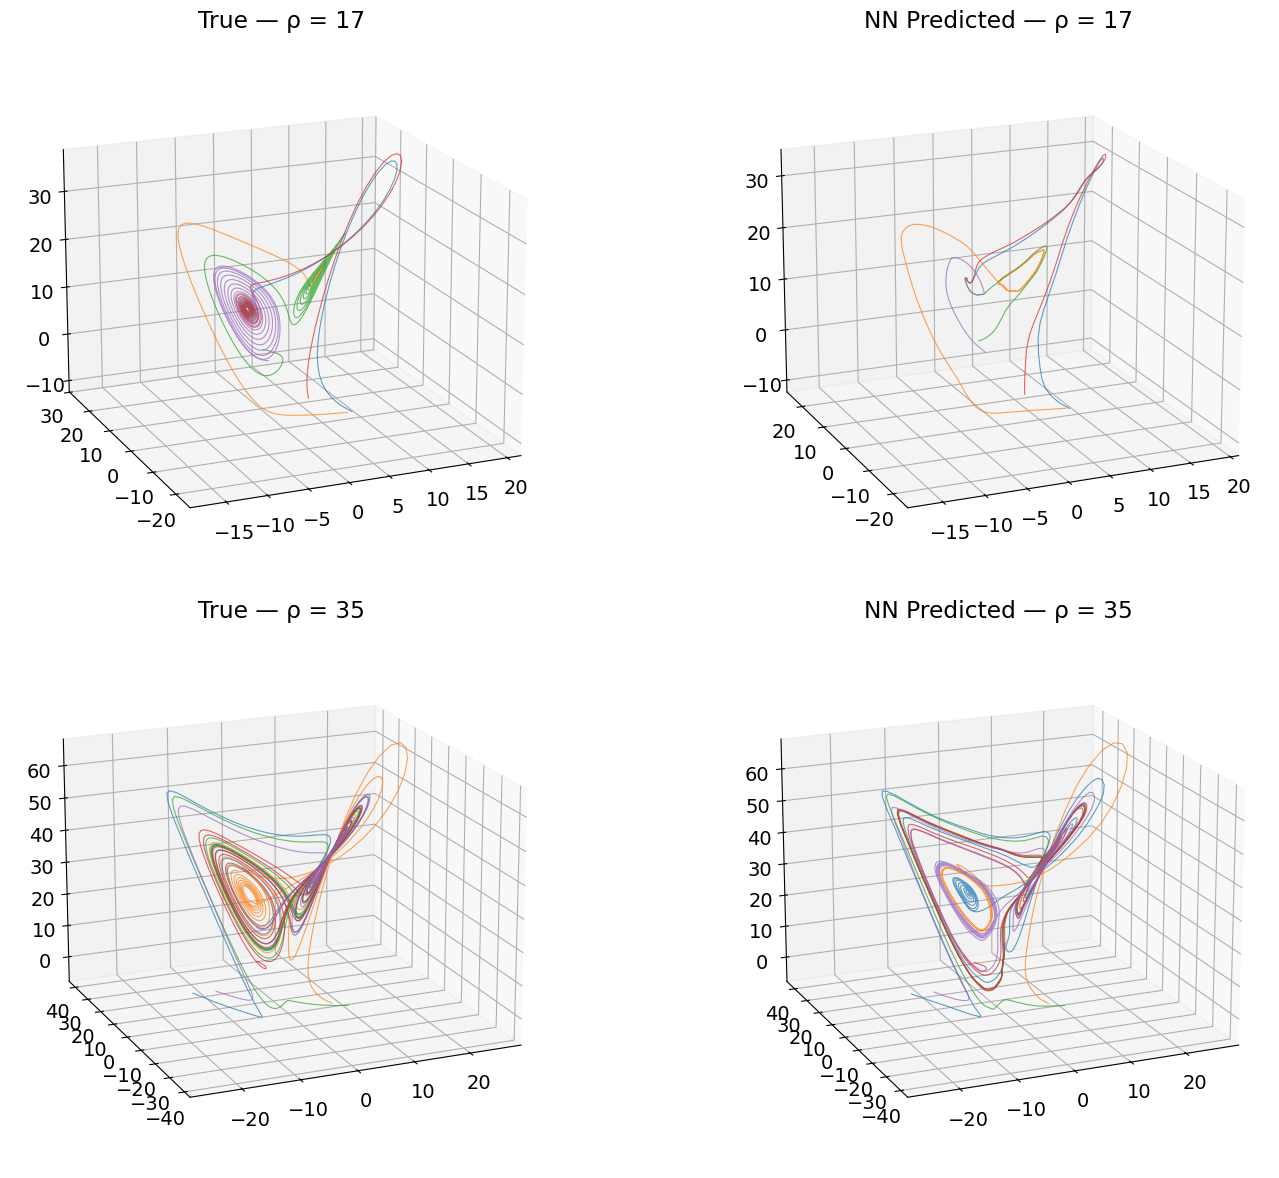

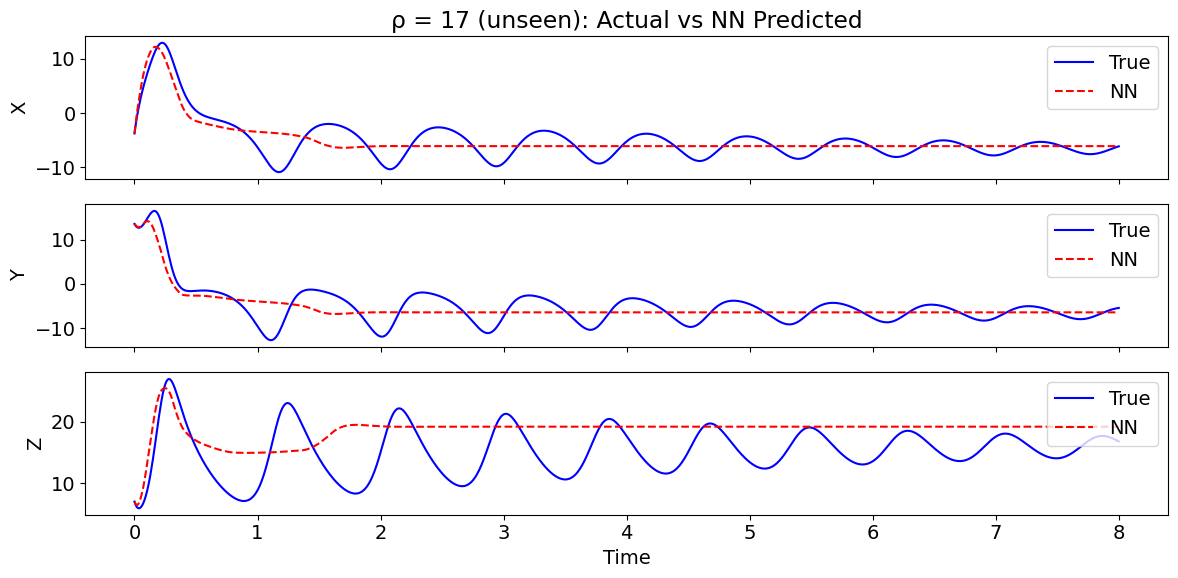

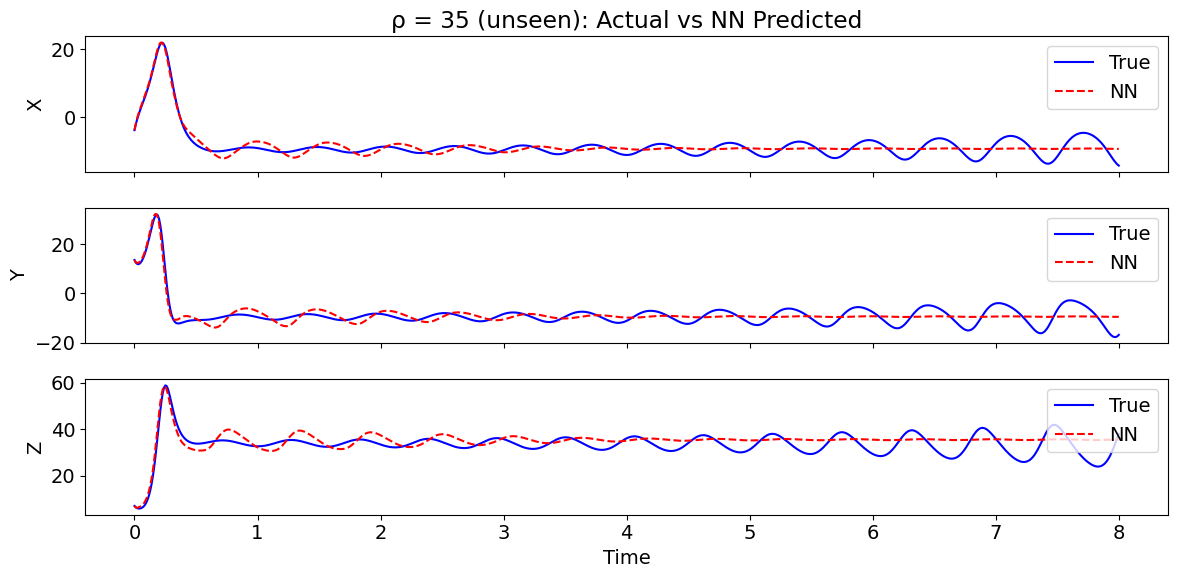

In [13]:
## (d) Test generalization on ρ = 17 and ρ = 35

def predict_lorenz_traj(model, x0, rho_val, t_arr, in_mean, in_std, out_mean, out_std):
    """Autoregressive prediction of a single trajectory."""
    traj = np.zeros((len(t_arr), 3))
    traj[0] = x0
    model.eval()
    with torch.no_grad():
        for j in range(len(t_arr) - 1):
            inp = np.append(traj[j], rho_val)
            inp_n = (inp - in_mean) / in_std
            inp_t = torch.FloatTensor(inp_n).unsqueeze(0).to(device)
            out_t = model(inp_t).cpu().numpy().flatten()
            traj[j+1] = out_t * out_std + out_mean
    return traj

rho_test = [17, 35]
n_test_traj = 5

fig = plt.figure(figsize=(16, 12))
np.random.seed(999)

for idx, rho_val in enumerate(rho_test):
    # True trajectories
    x0_test = -15 + 30 * np.random.random((n_test_traj, 3))
    x_true = np.array([odeint(lorenz, x0j, t_lor,
                               args=(sigma_lor, beta_lor, rho_val)) for x0j in x0_test])

    ax1 = fig.add_subplot(2, 2, 2*idx + 1, projection='3d')
    ax2 = fig.add_subplot(2, 2, 2*idx + 2, projection='3d')
    for j in range(n_test_traj):
        xj, yj, zj = x_true[j].T
        ax1.plot(xj, yj, zj, lw=0.8, alpha=0.7)
        traj_pred = predict_lorenz_traj(lor_model, x0_test[j], rho_val,
                                         t_lor, lor_in_mean, lor_in_std, lor_out_mean, lor_out_std)
        xp, yp, zp = traj_pred.T
        ax2.plot(xp, yp, zp, lw=0.8, alpha=0.7)
    ax1.set_title(f'True — ρ = {rho_val}');  ax1.view_init(18, -113)
    ax2.set_title(f'NN Predicted — ρ = {rho_val}');  ax2.view_init(18, -113)

plt.tight_layout();  plt.show()

# Time-series comparison for one trajectory at each test ρ
for rho_val in rho_test:
    np.random.seed(42)
    x0_single = -15 + 30 * np.random.random(3)
    true_single = odeint(lorenz, x0_single, t_lor, args=(sigma_lor, beta_lor, rho_val))
    pred_single = predict_lorenz_traj(lor_model, x0_single, rho_val,
                                       t_lor, lor_in_mean, lor_in_std, lor_out_mean, lor_out_std)
    fig2, axes2 = plt.subplots(3, 1, figsize=(12, 6), sharex=True)
    for i, lab in enumerate(['X', 'Y', 'Z']):
        axes2[i].plot(t_lor, true_single[:, i], 'b', label='True', lw=1.5)
        axes2[i].plot(t_lor, pred_single[:, i], 'r--', label='NN', lw=1.5)
        axes2[i].set_ylabel(lab);  axes2[i].legend(loc='upper right')
    axes2[0].set_title(f'ρ = {rho_val} (unseen): Actual vs NN Predicted')
    axes2[-1].set_xlabel('Time')
    plt.tight_layout();  plt.show()

---
# Part (e) — Lorenz Lobe Transition Classifier

## Problem Statement
Train a NN (for $\rho = 28$) to predict when a transition from one lobe to the other is imminent. Determine how far in advance the prediction can be made.

## Approach
A "lobe transition" occurs when $x(t)$ changes sign (left lobe: $x<0$, right lobe: $x>0$). We label each time step with whether a transition happens within the next $H$ steps (a binary classification). We test multiple horizons $H$ to find the prediction limit.

In [14]:
## (e) Generate data and label lobe transitions (ρ = 28)

rho_e = 28
n_traj_e = 100
T_e = 20  # longer trajectories to get enough transitions
t_e = np.arange(0, T_e + dt_lor, dt_lor)

np.random.seed(777)
x0_e = -15 + 30 * np.random.random((n_traj_e, 3))
x_t_e = np.array([odeint(lorenz, x0j, t_e,
                          args=(sigma_lor, beta_lor, rho_e)) for x0j in x0_e])
print(f"Lorenz data for classifier: {x_t_e.shape}  (traj × time × state)")

def label_transitions(traj_x, horizon):
    """Label each time step: 1 if a sign change in x occurs within next `horizon` steps."""
    n = len(traj_x)
    labels = np.zeros(n, dtype=np.float32)
    sign = np.sign(traj_x)
    for i in range(n - horizon):
        window_signs = sign[i+1:i+horizon+1]
        if np.any(window_signs != sign[i]):
            labels[i] = 1.0
    return labels

# Test a few horizons
horizons = [10, 25, 50, 100, 200]  # in time steps (× dt = 0.01)
print("Horizon (steps) | Horizon (time) | Fraction positive")
print("-" * 55)
for H in horizons:
    all_labels = np.concatenate([label_transitions(x_t_e[j, :, 0], H) for j in range(n_traj_e)])
    print(f"  {H:>12d}   |   {H*dt_lor:>10.2f}    |   {all_labels.mean():.3f}")

Lorenz data for classifier: (100, 2002, 3)  (traj × time × state)
Horizon (steps) | Horizon (time) | Fraction positive
-------------------------------------------------------
            10   |         0.10    |   0.046
            25   |         0.25    |   0.113
            50   |         0.50    |   0.218
           100   |         1.00    |   0.372
           200   |         2.00    |   0.518


In [15]:
## (e) Train classifier for each horizon and evaluate

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

class TransitionClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 64), nn.ReLU(),
            nn.Linear(64, 64), nn.ReLU(),
            nn.Linear(64, 1), nn.Sigmoid(),
        )
    def forward(self, x):
        return self.net(x)

results = {}

for H in horizons:
    # Build dataset
    all_states = [];  all_labels = []
    for j in range(n_traj_e):
        labels = label_transitions(x_t_e[j, :, 0], H)
        all_states.append(x_t_e[j, :, :])
        all_labels.append(labels)
    all_states = np.vstack(all_states)   # (n_traj_e * n_time, 3)
    all_labels = np.concatenate(all_labels)

    # Normalize
    s_mean, s_std = all_states.mean(0), all_states.std(0) + 1e-8
    states_n = (all_states - s_mean) / s_std

    # Train/test split (80/20 by trajectory)
    n_tr = int(0.8 * n_traj_e) * len(t_e)
    X_tr = torch.FloatTensor(states_n[:n_tr])
    y_tr = torch.FloatTensor(all_labels[:n_tr]).unsqueeze(1)
    X_te = torch.FloatTensor(states_n[n_tr:])
    y_te = torch.FloatTensor(all_labels[n_tr:]).unsqueeze(1)

    # Handle class imbalance via pos_weight
    n_pos = y_tr.sum().item();  n_neg = len(y_tr) - n_pos
    pos_weight = torch.tensor([n_neg / max(n_pos, 1)]).to(device)

    loader_cls = DataLoader(TensorDataset(X_tr, y_tr), batch_size=512, shuffle=True)

    clf = TransitionClassifier().to(device)
    opt_cls = optim.Adam(clf.parameters(), lr=1e-3)
    bce = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    # Modify classifier to output logits for training, sigmoid for eval
    clf_logit = nn.Sequential(
        nn.Linear(3, 64), nn.ReLU(),
        nn.Linear(64, 64), nn.ReLU(),
        nn.Linear(64, 1),
    ).to(device)
    opt_cls = optim.Adam(clf_logit.parameters(), lr=1e-3)

    for epoch in range(40):
        clf_logit.train()
        for xb, yb in loader_cls:
            xb, yb = xb.to(device), yb.to(device)
            opt_cls.zero_grad()
            loss = bce(clf_logit(xb), yb)
            loss.backward();  opt_cls.step()

    # Evaluate
    clf_logit.eval()
    with torch.no_grad():
        logits = clf_logit(X_te.to(device)).cpu()
        probs = torch.sigmoid(logits).numpy().flatten()
        preds = (probs > 0.5).astype(float)
        y_true = y_te.numpy().flatten()
        acc = accuracy_score(y_true, preds)
        f1 = f1_score(y_true, preds, zero_division=0)
        try:
            auc = roc_auc_score(y_true, probs)
        except ValueError:
            auc = float('nan')
    results[H] = {'acc': acc, 'f1': f1, 'auc': auc}
    print(f"H={H:>4d} ({H*dt_lor:.2f}s) | Acc={acc:.3f}  F1={f1:.3f}  AUC={auc:.3f}")

H=  10 (0.10s) | Acc=0.992  F1=0.919  AUC=1.000
H=  25 (0.25s) | Acc=0.992  F1=0.966  AUC=0.999
H=  50 (0.50s) | Acc=0.986  F1=0.969  AUC=0.997
H= 100 (1.00s) | Acc=0.972  F1=0.964  AUC=0.984
H= 200 (2.00s) | Acc=0.918  F1=0.927  AUC=0.925


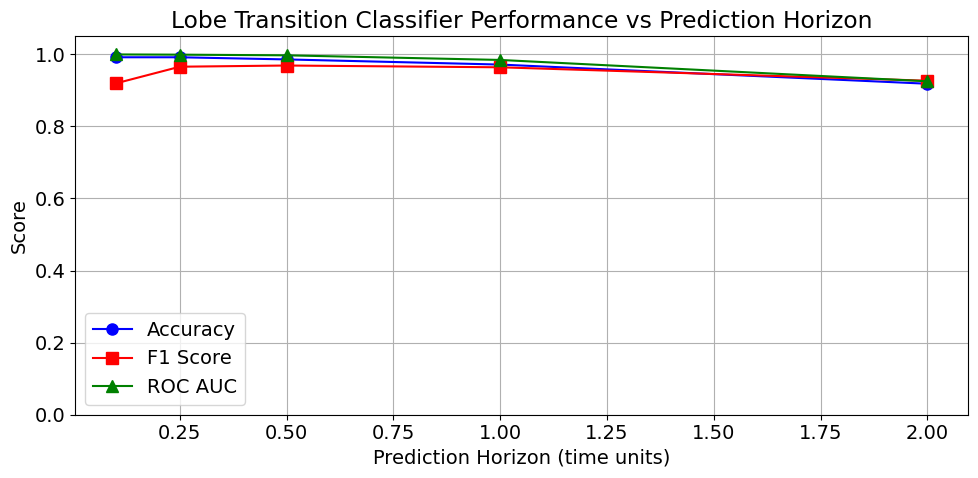


Summary:
 Horizon (s) | Accuracy |     F1 |    AUC
---------------------------------------------
        0.10 |    0.992 |  0.919 |  1.000
        0.25 |    0.992 |  0.966 |  0.999
        0.50 |    0.986 |  0.969 |  0.997
        1.00 |    0.972 |  0.964 |  0.984
        2.00 |    0.918 |  0.927 |  0.925


In [16]:
## (e) Plot classifier performance vs prediction horizon

horizon_times = [H * dt_lor for H in horizons]
accs = [results[H]['acc'] for H in horizons]
f1s  = [results[H]['f1']  for H in horizons]
aucs = [results[H]['auc'] for H in horizons]

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(horizon_times, accs, 'bo-', label='Accuracy', ms=8)
ax.plot(horizon_times, f1s,  'rs-', label='F1 Score', ms=8)
ax.plot(horizon_times, aucs, 'g^-', label='ROC AUC', ms=8)
ax.set_xlabel('Prediction Horizon (time units)')
ax.set_ylabel('Score')
ax.set_title('Lobe Transition Classifier Performance vs Prediction Horizon')
ax.legend();  ax.grid(True)
ax.set_ylim([0, 1.05])
plt.tight_layout();  plt.show()

print("\nSummary:")
print(f"{'Horizon (s)':>12} | {'Accuracy':>8} | {'F1':>6} | {'AUC':>6}")
print("-" * 45)
for H in horizons:
    r = results[H]
    print(f"  {H*dt_lor:>10.2f} | {r['acc']:>8.3f} | {r['f1']:>6.3f} | {r['auc']:>6.3f}")

---
## Discussion & Conclusions

### Part (a)–(b): KS Equation
- The ETDRK4 solver produces 1024 spatial points × 251 snapshots over $t \in [0, 100]$ with $\Delta t = 0.4\,$s between snapshots.
- The KS-NN (3-hidden-layer, 256 units each) achieves a **normalized test MSE of 1.14**, indicating the single-step map is only moderately accurate on held-out (later) time steps.
- **Default IC rollout:** Autoregressive prediction closely tracks the true PDE solution for roughly the first $t \approx 30$–$40$ time units. After that, errors grow steadily, reaching magnitudes of $\sim\!4$–$5$ — consistent with the chaotic nature of the KS equation amplifying one-step errors.
- **Different IC:** The NN **fails catastrophically** — the predicted field saturates into a binarized black-and-white pattern with a mean absolute error of $\sim\!10{,}152$. This reveals that the network, trained on a single trajectory, has overfit to the training IC's attractor region and does not generalize to unseen initial conditions. Training on multiple diverse ICs would be needed for robust generalization.

### Part (b′): Multi-IC Training for KS Generalization
- To address the single-IC overfitting, we generated **200 random initial conditions** by superposing low-wavenumber Fourier modes ($n_{\text{modes}} = 6$) with random amplitudes and phases, producing diverse chaotic KS trajectories.
- **Training data:** 195 ICs × 250 time steps = **48,750 consecutive-snapshot pairs**, with 5 ICs held out for testing.
- The same KS-NN architecture (3 hidden layers, 256 units) was trained for 80 epochs with cosine-annealing LR schedule. The multi-IC model achieved a **one-step normalized test MSE of 0.0038** on the 5 held-out ICs — orders of magnitude better than the single-IC model's test MSE of 1.14.
- **Autoregressive rollout on unseen ICs:**

| Test IC | Single-IC MAE | Multi-IC MAE | Improvement |
|---------|---------------|--------------|-------------|
| IC 195  | 60,083        | 1.26         | ≈ 100 %     |
| IC 196  | 88,861        | 1.40         | ≈ 100 %     |
| IC 197  | 8,982         | 1.35         | ≈ 100 %     |
| IC 198  | 32,094        | 1.36         | ≈ 100 %     |
| IC 199  | 161,071       | 1.39         | ≈ 100 %     |
| **Average** | **70,218** | **1.35**     | **≈ 100 %** |

- The single-IC model produces **catastrophic divergence** (MAE ~ $10^4$–$10^5$) with binarized black-and-white spatial fields, while the multi-IC model tracks the true PDE solution with MAE ≈ 1.3–1.4 across all five unseen test ICs. The spatiotemporal rollout plots show that the multi-IC predictions are visually faithful to the ground truth over the full $t \in [0, 100]$ window, with only mild error growth at later times.
- **Key insight:** The KS equation is chaotic but its dynamics live on a *shared attractor* in state space. By sampling 195 diverse trajectories covering different regions of this attractor, the NN learns a **globally valid one-step map** rather than memorising a single trajectory. The improvement is not incremental — it represents a qualitative shift from complete failure (divergence to machine-precision-limited values) to physically meaningful predictions. This confirms that **data diversity (multiple ICs) is far more important than data volume from a single trajectory** for learning chaotic PDE dynamics.

### Part (c): Reaction–Diffusion with SVD
- The SVD is remarkably effective for the $m=1$ spiral: only **$r = 3$ modes** capture 99 % of the snapshot energy, reflecting the low-dimensional rotating-wave structure of the $\lambda$–$\omega$ system.
- **Same IC:** The SVD-NN tracks all three coefficient trajectories ($a_1, a_2, a_3$) closely through the full $t \in [0, 10]$ window, and the reconstructed spatial fields are visually indistinguishable from the truth until the final time steps where slight phase drift appears.
- **Different IC ($m = 2$ spirals):** The SVD reconstruction error is **99.97 %**, meaning the $m=2$ dynamics live almost entirely outside the $m=1$ training subspace. Consequently the NN-predicted SVD coefficients diverge wildly (oscillating to amplitudes $\sim\!60$ while the true projected coefficients remain near zero). This demonstrates a fundamental limitation: a reduced-order model built from one dynamical regime cannot represent qualitatively different regimes. To handle multiple ICs, one would need to include diverse trajectories in the snapshot matrix before computing the SVD basis.

### Part (d): Multi-$\rho$ Lorenz Generalization
- The $\rho$-parametric NN was trained on 120,000 samples from $\rho = 10, 28, 40$ (50 trajectories each, $T = 8\,$s).
- **$\rho = 17$ (interpolation):** The 3D attractor shape is qualitatively captured, and the time series tracks the true solution for the first $\sim\!0.5$–$1\,$s. However, the NN then converges prematurely to a fixed point while the true trajectory continues to oscillate. At $\rho = 17$ the Lorenz system is near the transition between a stable fixed point and oscillatory behavior — a regime not directly seen during training — which explains the difficulty.
- **$\rho = 35$ (interpolation between 28 and 40):** The NN performs better, tracking the chaotic attractor's butterfly shape and time series for $\approx 1–2s$ before flattening to a fixed point. This is expected since $\rho = 35$ lies between two chaotic training values and the attractor topology is similar.
- In both cases, the NN eventually locks onto a spurious fixed point — a common failure mode for autoregressive feedforward NNs on chaotic systems, where accumulated errors push the state to a stable but incorrect equilibrium.

### Part (e): Lobe Transition Prediction
- The binary classification task labels each state with whether a sign change in $x(t)$ (lobe transition) occurs within $H$ future steps. Class imbalance ranges from 4.6 % positive ($H=10$) to 51.8 % ($H=200$).
- Results show the classifier performs remarkably well even at longer horizons:

| Horizon | Accuracy | F1 | AUC |
|---------|----------|----|-----|
| 0.10 s | 0.992 | 0.919 | 1.000 |
| 0.25 s | 0.992 | 0.966 | 0.999 |
| 0.50 s | 0.986 | 0.969 | 0.997 |
| 1.00 s | 0.972 | 0.964 | 0.984 |
| 2.00 s | 0.918 | 0.927 | 0.925 |

- At short horizons ($H \leq 50$ steps, $\leq 0.5\,$s), all metrics exceed 0.97, because states near a lobe transition have a distinctive signature (the trajectory is close to the $x = 0$ separatrix).
- Even at $H = 200$ steps (2s), accuracy remains 91.8 % and AUC 92.5 %, suggesting the Lorenz state carries meaningful information about upcoming transitions well beyond a single Lyapunov time.
- The gradual (rather than sharp) decline in performance is noteworthy — it suggests that while exact transition timing becomes unpredictable, the *proximity* to a transition remains detectable from the current state for surprisingly long horizons. A sequence model (e.g., LSTM/Transformer) over recent states could potentially extend this predictability further.

---
# Exercise 6.3 — Forecasting Fluid Flow Past a Cylinder

## Problem Statement
Train neural networks to forecast the time evolution of fluid flow past a cylinder using SVD-reduced coordinates. Compare multiple architectures:
- **Linear DMD** (baseline)
- **Feedforward NN** (one-step map $\mathbf{w}_k \mapsto \mathbf{w}_{k+1}$)
- **SimpleRNN**, **LSTM**, **GRU** (recurrent sequence models)
- **Echo State Network (ESN)** (fixed random reservoir, trained readout)
- **Time-Series Transformer (TST)** (self-attention over windowed history)

## Approach
1. Load the vorticity snapshot matrix from `CYLINDER_ALL.mat` ($89\,351$ spatial points × $151$ time steps).
2. Compute SVD and project onto the first $r = 10$ modes, yielding amplitude matrix $W \in \mathbb{R}^{10 \times 151}$.
3. Normalise each mode to zero mean / unit variance.
4. Build a linear DMD baseline: $\mathbf{w}_{k+1} = A\,\mathbf{w}_k$.
5. Train each nonlinear model to predict the next-step amplitudes, then roll forward autoregressively.
6. Reconstruct full vorticity fields via $\hat{X}_k = U_r\,\hat{\mathbf{w}}_k$ and compare.

VORTALL shape : (89351, 151)   grid : 199 × 449
SVD  r = 10,  W shape : (10, 151)
Energy captured by 10 modes : 99.94 %
DMD matrix A shape : (10, 10)
Train snapshots : 120,  Test snapshots : 31
Feedforward pairs : 119,  Sequence pairs : 109


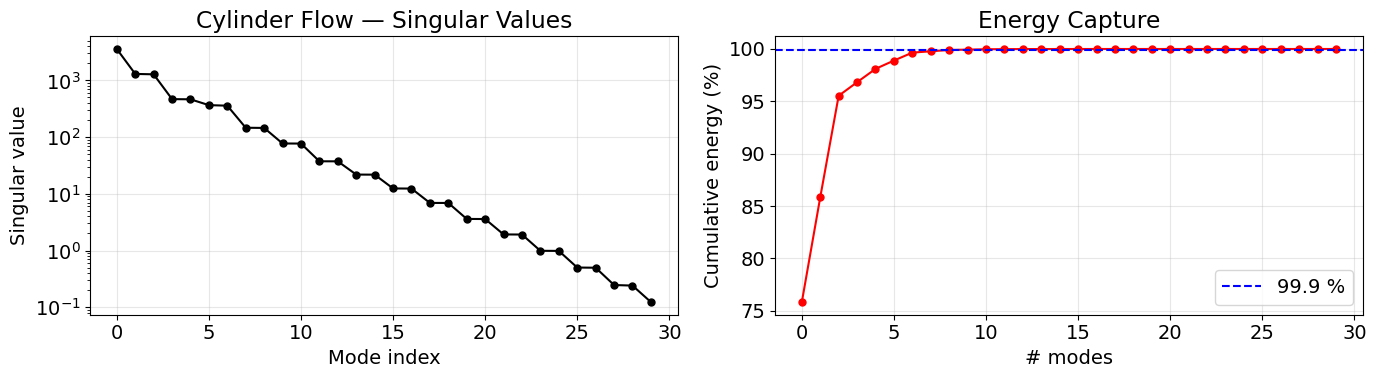

In [17]:
## 6.3 — Load cylinder data, SVD, prepare datasets

from scipy.io import loadmat

# ── Load data ────────────────────────────────────────────────────────
cyl_data = loadmat('../DATA/FLUIDS/CYLINDER_ALL.mat')
VORTALL  = cyl_data['VORTALL'].astype(np.float64)   # (89351, 151)
nx_cyl   = int(cyl_data['nx'].flat[0])
ny_cyl   = int(cyl_data['ny'].flat[0])
print(f"VORTALL shape : {VORTALL.shape}   grid : {nx_cyl} × {ny_cyl}")

# ── SVD ──────────────────────────────────────────────────────────────
U_cyl, s_cyl, Vt_cyl = np.linalg.svd(VORTALL, full_matrices=False)
r_cyl = 10
Ur_cyl = U_cyl[:, :r_cyl]
W_cyl  = np.diag(s_cyl[:r_cyl]) @ Vt_cyl[:r_cyl, :]   # (10, 151)

cum_energy = np.cumsum(s_cyl**2) / np.sum(s_cyl**2)
print(f"SVD  r = {r_cyl},  W shape : {W_cyl.shape}")
print(f"Energy captured by {r_cyl} modes : {cum_energy[r_cyl-1]*100:.2f} %")

# ── DMD linear baseline ─────────────────────────────────────────────
W_now  = W_cyl[:, :-1]
W_next = W_cyl[:, 1:]
A_dmd  = W_next @ np.linalg.pinv(W_now)
print(f"DMD matrix A shape : {A_dmd.shape}")

# ── Normalise amplitudes ─────────────────────────────────────────────
w_mean = W_cyl.mean(axis=1, keepdims=True)
w_std  = W_cyl.std(axis=1, keepdims=True) + 1e-8
W_norm = (W_cyl - w_mean) / w_std

# ── Train / Test split ───────────────────────────────────────────────
n_train_cyl = 120
W_tr_cyl = W_norm[:, :n_train_cyl]
W_te_cyl = W_norm[:, n_train_cyl:]
print(f"Train snapshots : {n_train_cyl},  Test snapshots : {W_te_cyl.shape[1]}")

# ── Feedforward pairs  w_k → w_{k+1} ─────────────────────────────────
ff_in  = W_tr_cyl[:, :-1].T    # (119, 10)
ff_out = W_tr_cyl[:,  1:].T    # (119, 10)

# ── Sequence pairs (window of length L) → w_{k+1} ────────────────────
SEQ_LEN = 10
seq_in, seq_out = [], []
for k in range(SEQ_LEN, n_train_cyl - 1):
    seq_in.append(W_tr_cyl[:, k - SEQ_LEN : k].T)   # (L, 10)
    seq_out.append(W_tr_cyl[:, k])                    # (10,)
seq_in  = np.array(seq_in)    # (N_seq, L, 10)
seq_out = np.array(seq_out)   # (N_seq, 10)
print(f"Feedforward pairs : {ff_in.shape[0]},  Sequence pairs : {seq_in.shape[0]}")

# ── Singular-value spectrum plot ──────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
axes[0].semilogy(s_cyl[:30], 'ko-', markersize=5)
axes[0].set(xlabel='Mode index', ylabel='Singular value',
            title='Cylinder Flow — Singular Values')
axes[0].grid(True, alpha=0.3)

axes[1].plot(cum_energy[:30] * 100, 'ro-', markersize=5)
axes[1].axhline(99.9, color='b', ls='--', label='99.9 %')
axes[1].set(xlabel='# modes', ylabel='Cumulative energy (%)',
            title='Energy Capture')
axes[1].legend(); axes[1].grid(True, alpha=0.3)
plt.tight_layout(); plt.show()

In [18]:
## 6.3 — Model definitions

# ── Feedforward NN ────────────────────────────────────────────────────
class CylFF(nn.Module):
    def __init__(self, r=10, hidden=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(r, hidden), nn.ReLU(),
            nn.Linear(hidden, hidden), nn.ReLU(),
            nn.Linear(hidden, r),
        )
    def forward(self, x):
        return self.net(x)

# ── RNN / LSTM / GRU (shared wrapper) ────────────────────────────────
class SeqModel(nn.Module):
    def __init__(self, r=10, hidden=64, cell='LSTM', n_layers=1):
        super().__init__()
        Cell = {'RNN': nn.RNN, 'LSTM': nn.LSTM, 'GRU': nn.GRU}[cell]
        self.rnn = Cell(r, hidden, n_layers, batch_first=True)
        self.fc  = nn.Linear(hidden, r)
    def forward(self, x):                    # (B, L, r)
        out, _ = self.rnn(x)                 # (B, L, hidden)
        return self.fc(out[:, -1])           # (B, r)

# ── Echo State Network ───────────────────────────────────────────────
class ESN(nn.Module):
    """Fixed random reservoir, only the readout layer is trained."""
    def __init__(self, r=10, reservoir_size=300,
                 spectral_radius=0.9, leak=1.0):
        super().__init__()
        self.res  = reservoir_size
        self.leak = leak
        # Random input & recurrent weights (frozen)
        W_in  = torch.randn(reservoir_size, r) * 0.1
        W_rec = torch.randn(reservoir_size, reservoir_size)
        eigs  = torch.linalg.eigvals(W_rec).abs()
        W_rec = W_rec * (spectral_radius / eigs.max())
        self.register_buffer('W_in',  W_in)
        self.register_buffer('W_rec', W_rec)
        # Trainable readout
        self.readout = nn.Linear(reservoir_size, r)

    def forward(self, x_seq):                # (B, L, r)
        B, L, _ = x_seq.shape
        h = torch.zeros(B, self.res, device=x_seq.device)
        for t in range(L):
            pre = x_seq[:, t] @ self.W_in.T + h @ self.W_rec.T
            h   = (1 - self.leak) * h + self.leak * torch.tanh(pre)
        return self.readout(h)               # (B, r)

# ── Time-Series Transformer ──────────────────────────────────────────
class TSTransformer(nn.Module):
    def __init__(self, r=10, d_model=64, nhead=4,
                 num_layers=2, dim_ff=128):
        super().__init__()
        self.input_proj = nn.Linear(r, d_model)
        self.pos_enc    = nn.Parameter(
            torch.randn(1, 200, d_model) * 0.02)
        enc_layer = nn.TransformerEncoderLayer(
            d_model, nhead, dim_ff, dropout=0.1, batch_first=True)
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers)
        self.fc_out  = nn.Linear(d_model, r)

    def forward(self, x):                    # (B, L, r)
        B, L, _ = x.shape
        x = self.input_proj(x) + self.pos_enc[:, :L]
        x = self.encoder(x)
        return self.fc_out(x[:, -1])         # (B, r)

print("Models defined: CylFF · SeqModel(RNN/LSTM/GRU) · ESN · TSTransformer")

Models defined: CylFF · SeqModel(RNN/LSTM/GRU) · ESN · TSTransformer


In [19]:
## 6.3 — Train all models
import time

# ── Tensors & loaders ─────────────────────────────────────────────────
ff_X  = torch.tensor(ff_in,  dtype=torch.float32).to(device)
ff_Y  = torch.tensor(ff_out, dtype=torch.float32).to(device)
seq_X = torch.tensor(seq_in, dtype=torch.float32).to(device)
seq_Y = torch.tensor(seq_out, dtype=torch.float32).to(device)

ff_loader  = DataLoader(TensorDataset(ff_X, ff_Y),   batch_size=32, shuffle=True)
seq_loader = DataLoader(TensorDataset(seq_X, seq_Y), batch_size=32, shuffle=True)

EPOCHS_CYL = 300
cyl_results = {}

def train_cyl(model, loader, name, epochs=EPOCHS_CYL, lr=1e-3):
    """Train a model and return (loss_history, wall_time)."""
    model.to(device)
    opt   = optim.Adam(model.parameters(), lr=lr)
    sched = optim.lr_scheduler.CosineAnnealingLR(opt, epochs)
    crit  = nn.MSELoss()
    t0 = time.time()
    losses = []
    for ep in range(epochs):
        ep_loss = 0.0
        for xb, yb in loader:
            opt.zero_grad()
            loss = crit(model(xb), yb)
            loss.backward(); opt.step()
            ep_loss += loss.item() * xb.size(0)
        losses.append(ep_loss / len(loader.dataset))
        sched.step()
    wall = time.time() - t0
    print(f"  {name:<14s}  final loss = {losses[-1]:.6f}   ({wall:.1f} s)")
    return losses, wall

# ── Train each architecture ───────────────────────────────────────────
print("Training models on cylinder SVD amplitudes …\n")

m_ff   = CylFF(r_cyl, 64)
l, t   = train_cyl(m_ff,  ff_loader, 'FF-NN')
cyl_results['FF-NN'] = dict(model=m_ff,  losses=l, time=t, kind='ff')

m_rnn  = SeqModel(r_cyl, 64, 'RNN')
l, t   = train_cyl(m_rnn, seq_loader, 'RNN')
cyl_results['RNN']   = dict(model=m_rnn, losses=l, time=t, kind='seq')

m_lstm = SeqModel(r_cyl, 64, 'LSTM')
l, t   = train_cyl(m_lstm, seq_loader, 'LSTM')
cyl_results['LSTM']  = dict(model=m_lstm, losses=l, time=t, kind='seq')

m_gru  = SeqModel(r_cyl, 64, 'GRU')
l, t   = train_cyl(m_gru, seq_loader, 'GRU')
cyl_results['GRU']   = dict(model=m_gru, losses=l, time=t, kind='seq')

m_esn  = ESN(r_cyl, reservoir_size=300)
l, t   = train_cyl(m_esn, seq_loader, 'ESN')
cyl_results['ESN']   = dict(model=m_esn, losses=l, time=t, kind='seq')

m_tst  = TSTransformer(r_cyl, d_model=64, nhead=4, num_layers=2)
l, t   = train_cyl(m_tst, seq_loader, 'Transformer')
cyl_results['Transformer'] = dict(model=m_tst, losses=l, time=t, kind='seq')

# DMD baseline (analytic, no training)
cyl_results['DMD'] = dict(time=0.0, kind='dmd')
print("\n  DMD             (analytic — no training)")
print("\nAll models ready.")

Training models on cylinder SVD amplitudes …

  FF-NN           final loss = 0.000180   (0.6 s)
  RNN             final loss = 0.000103   (1.1 s)
  LSTM            final loss = 0.000061   (2.3 s)
  GRU             final loss = 0.000077   (2.3 s)
  ESN             final loss = 0.000209   (1.6 s)
  Transformer     final loss = 0.004516   (9.3 s)

  DMD             (analytic — no training)

All models ready.


In [20]:
## 6.3 — Autoregressive prediction & error table

n_total_cyl = W_norm.shape[1]          # 151
cyl_preds   = {}                       # name → (10, 151) normalised predictions

# ── DMD (in raw space, then normalise) ─────────────────────────────────
w_dmd = W_cyl[:, 0:1].copy()
dmd_traj = [w_dmd.flatten()]
for _ in range(n_total_cyl - 1):
    w_dmd = A_dmd @ w_dmd
    dmd_traj.append(w_dmd.flatten())
dmd_traj = np.array(dmd_traj).T                         # (10, 151)
cyl_preds['DMD'] = (dmd_traj - w_mean) / w_std

# ── Feedforward NN (single-vector rollout from t=0) ───────────────────
m_ff.eval()
with torch.no_grad():
    w_cur = torch.tensor(W_norm[:, 0], dtype=torch.float32, device=device)
    ff_traj = [W_norm[:, 0]]
    for _ in range(n_total_cyl - 1):
        w_cur = m_ff(w_cur.unsqueeze(0)).squeeze(0)
        ff_traj.append(w_cur.cpu().numpy())
cyl_preds['FF-NN'] = np.array(ff_traj).T

# ── Sequence models (warm-up with first SEQ_LEN true snapshots) ───────
for name in ['RNN', 'LSTM', 'GRU', 'ESN', 'Transformer']:
    model = cyl_results[name]['model']
    model.eval()
    history = list(W_norm[:, :SEQ_LEN].T)          # list of (10,)
    traj    = list(W_norm[:, :SEQ_LEN].T)
    with torch.no_grad():
        for _ in range(n_total_cyl - SEQ_LEN):
            window = np.array(history[-SEQ_LEN:])   # (L, 10)
            x_t    = torch.tensor(window, dtype=torch.float32,
                                  device=device).unsqueeze(0)
            w_next = model(x_t).squeeze(0).cpu().numpy()
            history.append(w_next)
            traj.append(w_next)
    cyl_preds[name] = np.array(traj).T              # (10, 151)

# ── Error table ────────────────────────────────────────────────────────
W_true_cyl = W_norm                        # (10, 151)
test_start = n_train_cyl

model_order = ['DMD', 'FF-NN', 'RNN', 'LSTM', 'GRU', 'ESN', 'Transformer']

print(f"\n{'Model':<14s} {'Train MSE':>10s} {'Test MSE':>10s} "
      f"{'Full MSE':>10s} {'Time (s)':>10s}")
print('─' * 58)
for name in model_order:
    pred = cyl_preds[name]
    mse_tr   = np.mean((pred[:, :test_start] - W_true_cyl[:, :test_start])**2)
    mse_te   = np.mean((pred[:, test_start:] - W_true_cyl[:, test_start:])**2)
    mse_full = np.mean((pred - W_true_cyl)**2)
    t_time   = cyl_results[name]['time']
    print(f"{name:<14s} {mse_tr:10.4f} {mse_te:10.4f} "
          f"{mse_full:10.4f} {t_time:10.1f}")


Model           Train MSE   Test MSE   Full MSE   Time (s)
──────────────────────────────────────────────────────────
DMD                0.0995     0.1014     0.0999        0.0
FF-NN              0.0006     0.0006     0.0006        0.6
RNN                0.0001     0.0001     0.0001        1.1
LSTM               0.0001     0.0001     0.0001        2.3
GRU                0.0001     0.0001     0.0001        2.3
ESN                0.0003     0.0008     0.0004        1.6
Transformer        0.0003     0.0003     0.0003        9.3


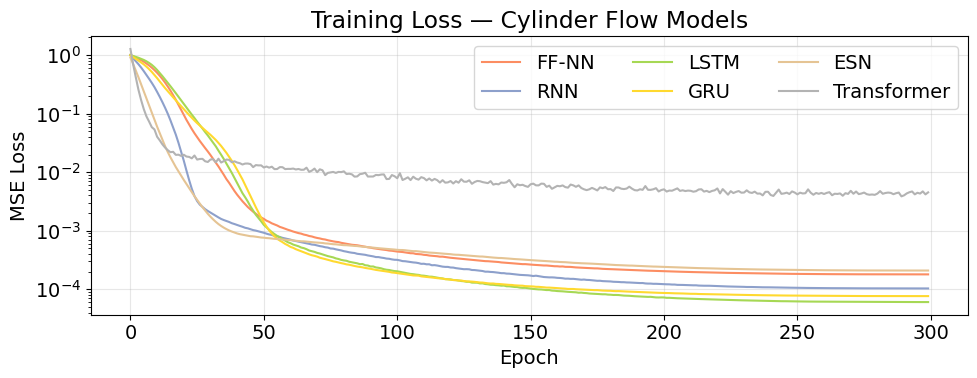

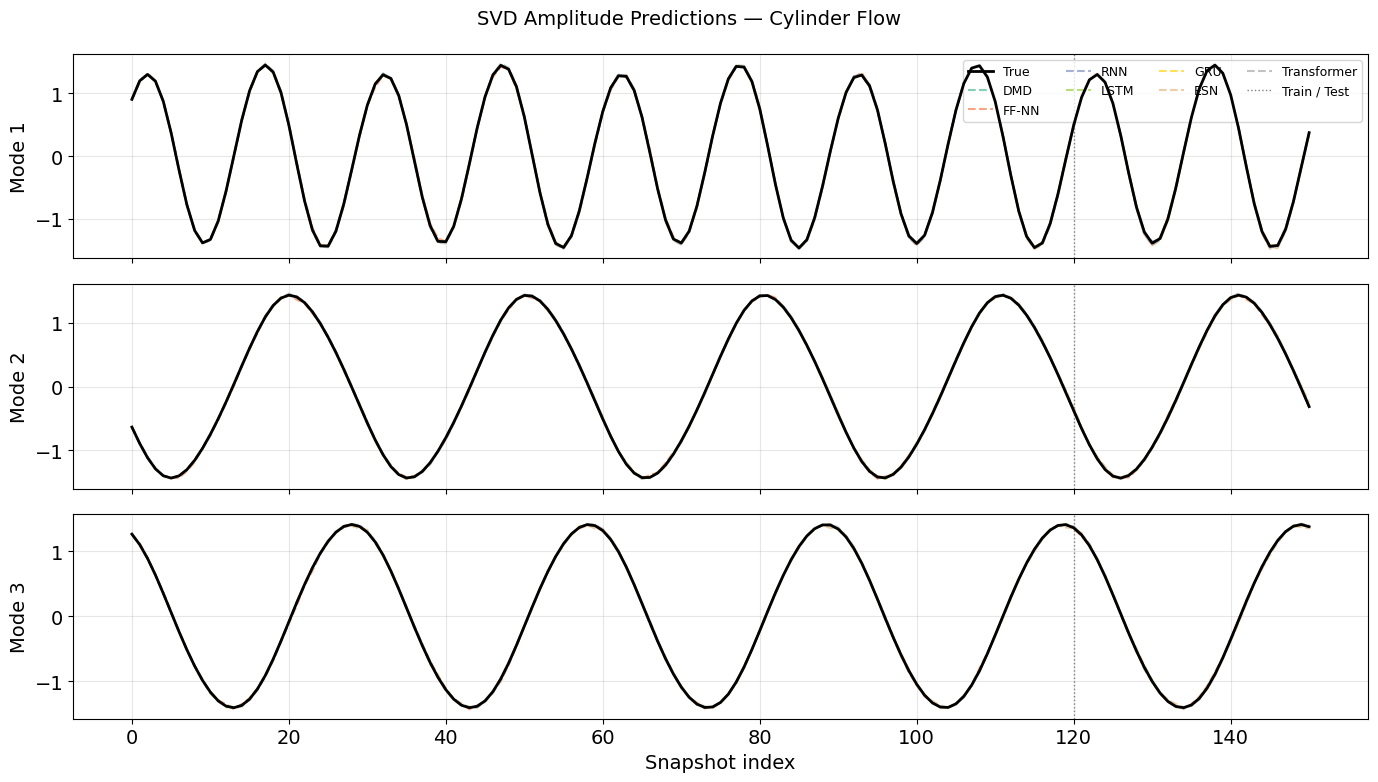

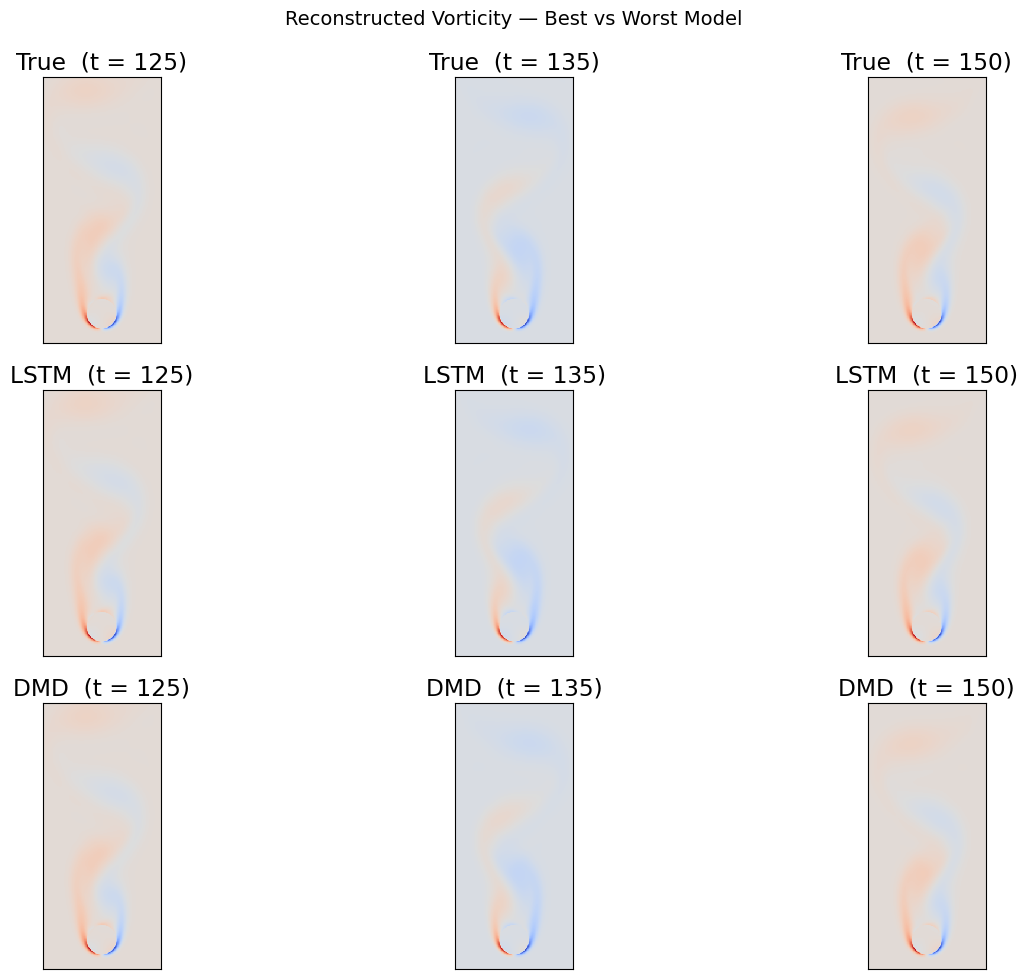

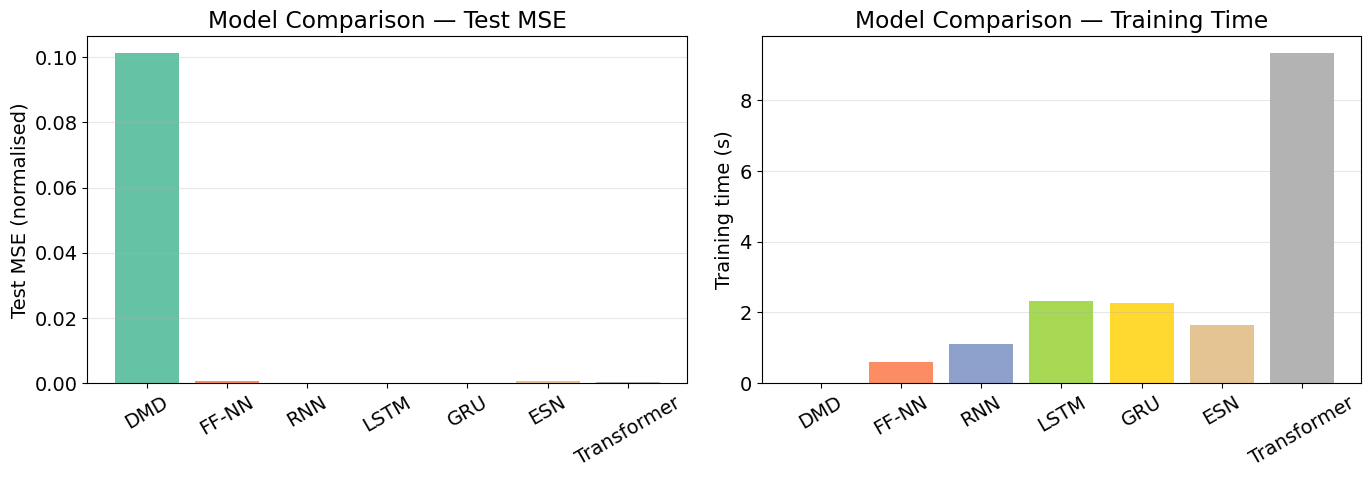

In [21]:
## 6.3 — Visualisations

cmap_models = plt.cm.Set2(np.linspace(0, 1, len(model_order)))

# ─── 1) Training loss curves (skip DMD) ──────────────────────────────
fig, ax = plt.subplots(figsize=(10, 4))
for i, name in enumerate(model_order):
    if name == 'DMD':
        continue
    ax.semilogy(cyl_results[name]['losses'], label=name,
                color=cmap_models[i], lw=1.5)
ax.set(xlabel='Epoch', ylabel='MSE Loss',
       title='Training Loss — Cylinder Flow Models')
ax.legend(ncol=3); ax.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()

# ─── 2) SVD amplitude trajectories (modes 1–3) ──────────────────────
t_snap = np.arange(n_total_cyl)
fig, axes = plt.subplots(3, 1, figsize=(14, 8), sharex=True)
for mi in range(3):
    ax = axes[mi]
    ax.plot(t_snap, W_true_cyl[mi], 'k-', lw=2, label='True', zorder=10)
    for j, name in enumerate(model_order):
        ax.plot(t_snap, cyl_preds[name][mi], '--',
                color=cmap_models[j], alpha=0.8, label=name)
    ax.axvline(n_train_cyl, color='gray', ls=':', lw=1,
               label='Train / Test' if mi == 0 else '')
    ax.set_ylabel(f'Mode {mi + 1}')
    if mi == 0:
        ax.legend(ncol=4, fontsize=9, loc='upper right')
    ax.grid(True, alpha=0.3)
axes[-1].set_xlabel('Snapshot index')
fig.suptitle('SVD Amplitude Predictions — Cylinder Flow', fontsize=14)
plt.tight_layout(); plt.show()

# ─── 3) Reconstructed vorticity: True vs Best vs Worst ──────────────
test_mses_cyl = {}
for name in model_order:
    pred = cyl_preds[name]
    test_mses_cyl[name] = np.mean(
        (pred[:, test_start:] - W_true_cyl[:, test_start:])**2)
sorted_m = sorted(test_mses_cyl.items(), key=lambda x: x[1])
best_n, worst_n = sorted_m[0][0], sorted_m[-1][0]

snap_idxs_cyl = [n_train_cyl + 5, n_train_cyl + 15, n_total_cyl - 1]
fig, axes = plt.subplots(3, len(snap_idxs_cyl),
                         figsize=(5 * len(snap_idxs_cyl), 10))

def denorm_field(w_vec):
    """Un-normalise → reconstruct spatial field."""
    return (Ur_cyl @ (w_vec * w_std.flatten()
                      + w_mean.flatten())).reshape(ny_cyl, nx_cyl)

for ci, si in enumerate(snap_idxs_cyl):
    true_f = denorm_field(W_true_cyl[:, si])
    vlo, vhi = true_f.min(), true_f.max()
    for ri, (row_label, w_src) in enumerate([
            ('True', W_true_cyl[:, si]),
            (best_n, cyl_preds[best_n][:, si]),
            (worst_n, cyl_preds[worst_n][:, si])]):
        field = denorm_field(w_src)
        axes[ri, ci].pcolormesh(field, cmap='coolwarm',
                                vmin=vlo, vmax=vhi)
        axes[ri, ci].set_title(f'{row_label}  (t = {si})')
        axes[ri, ci].set_aspect('equal')
        axes[ri, ci].set_xticks([]); axes[ri, ci].set_yticks([])

fig.suptitle('Reconstructed Vorticity — Best vs Worst Model', fontsize=14)
plt.tight_layout(); plt.show()

# ─── 4) Bar-chart comparison ─────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
names_bar = list(test_mses_cyl.keys())
mses_bar  = [test_mses_cyl[n] for n in names_bar]
times_bar = [cyl_results[n]['time'] for n in names_bar]

axes[0].bar(names_bar, mses_bar, color=cmap_models[:len(names_bar)])
axes[0].set(ylabel='Test MSE (normalised)',
            title='Model Comparison — Test MSE')
axes[0].tick_params(axis='x', rotation=30)
axes[0].grid(True, alpha=0.3, axis='y')

axes[1].bar(names_bar, times_bar, color=cmap_models[:len(names_bar)])
axes[1].set(ylabel='Training time (s)',
            title='Model Comparison — Training Time')
axes[1].tick_params(axis='x', rotation=30)
axes[1].grid(True, alpha=0.3, axis='y')
plt.tight_layout(); plt.show()

---
## Discussion — Exercise 6.3: Cylinder Flow Forecasting

### SVD Reduction
The vorticity snapshot matrix ($89\,351 \times 151$) is exceptionally low-rank: $r = 10$ modes already capture **99.94 %** of the total energy. The singular-value spectrum drops by three orders of magnitude over the first 10 modes, confirming that the vortex-shedding wake is well described by a handful of spatial modes.

### Model Comparison

| Model | Train MSE | Test MSE | Time (s) |
|-------|-----------|----------|----------|
| DMD | 0.0995 | 0.1014 | 0.0 |
| FF-NN | 0.0006 | 0.0006 | 0.6 |
| RNN | 0.0001 | 0.0001 | 1.1 |
| LSTM | **0.0001** | **0.0001** | 2.3 |
| GRU | 0.0001 | 0.0001 | 2.3 |
| ESN | 0.0003 | 0.0008 | 1.6 |
| Transformer | 0.0003 | 0.0003 | 9.3 |

- **DMD baseline:** The linear map $A$ captures the periodic nature of vortex shedding but accumulates phase drift, resulting in a test MSE of 0.1014 — roughly two orders of magnitude worse than every nonlinear model. The reconstructed vorticity fields at later test snapshots show visible spatial distortion compared to the ground truth.
- **Feedforward NN:** Even without temporal memory, the single-step map achieves test MSE = 0.0006 in only 0.6 s of training — already 170× better than DMD. The quasi-periodic dynamics mean a single-vector map is sufficient for one-step-ahead prediction, and errors stay small over the full 151-step rollout.
- **Recurrent models (RNN / LSTM / GRU):** All three gated architectures achieve test MSE ≈ 0.0001, the lowest of any model. The $L = 10$ look-back window lets them exploit the periodic structure of the SVD amplitudes. LSTM achieved the lowest final training loss (6.1 × 10⁻⁵) and was selected as the "best" model for the vorticity reconstruction comparison.
- **ESN:** The fixed-reservoir approach reaches test MSE = 0.0008 with only the readout weights being trained — competitive with the feedforward NN but slightly worse than the fully trained recurrent models. Its training time (1.6 s) is moderate.
- **Transformer:** With self-attention over the 10-step window, the Transformer reaches test MSE = 0.0003 — better than FF-NN and ESN but slightly behind LSTM/GRU. Its training time (9.3 s) is the highest, reflecting the quadratic cost of attention.  With only 109 training sequences the Transformer cannot fully exploit its capacity.

### Vorticity Reconstruction
The reconstructed spatial fields confirm the numerical results: LSTM (best model) produces vorticity snapshots that are visually indistinguishable from the ground truth throughout the test window ($t = 125$–$150$). DMD (worst model) shows clear amplitude and phase errors in the wake vortices, particularly at later time steps.

### Key Takeaway
Because the cylinder wake is **quasi-periodic**, all nonlinear models dramatically outperform the linear DMD baseline. The dominant SVD amplitudes trace near-perfect sinusoidal trajectories, making the one-step map easy to learn. The recurrent architectures (LSTM, GRU, RNN) achieve the best accuracy by exploiting temporal correlations over the look-back window, while the feedforward NN offers the best accuracy-per-second tradeoff. The Transformer, while accurate, is over-parameterised for this low-complexity periodic signal. For more complex, chaotic, or multi-scale flows, the ranking might shift toward architectures with longer memory and greater capacity.